# TEAM 25 

# Introduction:

This notebook was used for experimenting the deep learning models. Multiple network architectures were explored inlcuding:

1. MLP (fully-connected newtork) with Focal Loss and Balanced Weights. The focal loss was included as it accounts for the class imbalance during model training. Different gamma values were explored to see their performance variations. Gamma value of 2 yielded better results. 

2. Tabnet (with and without balanced weights) - Appendix

The custom model provided acceptable results and was included in the final presentation. 


### Setup

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
#Gradient Color Bar Plots
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import colors as mcolors, path

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import chi2
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_selection import RFE, RFECV
from pytorch_tabnet.tab_model import TabNetClassifier

from embedding_encoder import EmbeddingEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.ensemble import VotingClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

pd.options.display.max_columns= 100
import warnings
warnings.filterwarnings('ignore')

C:\Users\dhava\anaconda3\envs\MEng\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [43]:
import itertools

### Helper Functions

In [2]:
def gradientbars(bars,ydata,cmap):
    ax = bars[0].axes
    lim = ax.get_xlim()+ax.get_ylim()
    ax.axis(lim)
    for bar in bars:
        bar.set_facecolor("none")
        x,y = bar.get_xy()
        w, h = bar.get_width(), bar.get_height()
        grad = np.atleast_2d(np.linspace(0,1*h/max(ydata),256)).T
        #zorder of 2 to get gradients above the facecolor, but below the bar outlines
        ax.imshow(grad, extent=[x,x+w,y,y+h], origin='lower',aspect="auto",zorder=2, norm=cm.colors.NoNorm(vmin=0,vmax=1),cmap=plt.get_cmap(cmap))

def get_weight_total_results(weights_dict):
    results_tot = pd.concat([pd.concat([key, pd.Series([val for i in range(4)], index=key.index)], axis=1) for val, key in weights_dict.items()], axis=0)
    results_tot.rename({0:'case'}, axis=1, inplace=True)

    train_scores = pd.concat([results_tot[['train', 'case']], pd.Series(['train' for i in range(len(results_tot))], index=results_tot.index)], axis=1)
    train_scores.rename({0:'split', 'train':'scores'}, axis=1, inplace=True)
    val_scores = pd.concat([results_tot[['val', 'case']], pd.Series(['val' for i in range(len(results_tot))], index=results_tot.index)], axis=1)
    val_scores.rename({0:'split', 'val':'scores'}, axis=1, inplace=True)
    test_scores = pd.concat([results_tot[['test', 'case']], pd.Series(['test' for i in range(len(results_tot))], index=results_tot.index)], axis=1)
    test_scores.rename({0:'split', 'test':'scores'}, axis=1, inplace=True)

    results_tot = pd.concat([train_scores, val_scores, test_scores], axis=0).reset_index()
    #results_tot = results_tot[results_tot.index!='low'].reset_index()
    
    return results_tot        

        
def get_results_list(row, results):
    res = []
    for model, result in results.items():
        for col in ['train', 'val', 'test']:
                res.append([model, result.loc[row, col], col])
    return pd.DataFrame(res, columns=['model', 'score', 'split'])
        
class PreprocessData(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 num_cols, 
                 cat_ohe_cols, 
                 #cat_high_cols,
                 cat_non_ohe_cols=[], 
                 imputer=SimpleImputer(strategy='most_frequent'),
                 scaler=StandardScaler(),
                 ohe=OneHotEncoder(handle_unknown='ignore'),
                 #embedder=EmbeddingEncoder(task="classification")
                 ):
   
        self.num_cols = num_cols
        self.cat_ohe_cols = cat_ohe_cols
        #self.cat_high_cols = cat_high_cols
        self.cat_non_ohe_cols = cat_non_ohe_cols
        self.imputer = imputer
        self.scaler = scaler
        self.ohe = ohe if self.cat_ohe_cols else False
        #self.embedder= embedder if self.cat_high_cols else False
        self.numerical_pipeline = Pipeline(steps=[('scaler', self.scaler)])
        self.categorical_pipeline = Pipeline(steps=[('ohe', self.ohe)])
        if self.ohe:
            self.preprocessor = ColumnTransformer(transformers=[('num', self.numerical_pipeline, num_cols),
                                                   ('cat', self.categorical_pipeline, cat_ohe_cols)],
                                     remainder='passthrough')
        else:
            self.preprocessor = ColumnTransformer(transformers=[('num', self.numerical_pipeline, num_cols)],
                                 remainder='passthrough')
        
    def fit(self, X, y=None):
        self.preprocessor.fit(X)
        if self.ohe:
            self.cat_cols_name = list(self.preprocessor.transformers_[1][1]['ohe'].get_feature_names(self.cat_ohe_cols))
        else:
            self.cat_cols_name = []
        return self
    
    def transform(self, X, y=None):
        
        X = pd.DataFrame(self.preprocessor.transform(X), columns=self.num_cols+self.cat_cols_name+self.cat_non_ohe_cols)
        return X
        
#     def ocptn_fe(self, X, y, test=False):
#         if not test:
#             pd.concat([X['OCPTN_NM'], y.reset_index(drop=True)], axis=1).groupby()
 
#         return X

def get_data(data,
             num_cols, 
             cat_ohe_cols, 
             cat_non_ohe_cols,
             n_folds=10,
             model_type='Catboost'):

    temp = data.copy()
    
    if cat_non_ohe_cols:
        for col in cat_non_ohe_cols:
            label_encoder = LabelEncoder()
            temp[col] = label_encoder.fit_transform(temp[col])


    temp.drop(['BIRTH_DT', 'CUST_ADD_DT', 'NAME', 'GENDER', 'CUSTOMER_ID', 'CNTRY_OF_INCOME_CA',
              'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY', 'RES_CNTRY_CA'], axis=1, inplace=True)
    try:
        temp['OCPTN_NM'] = temp['OCPTN_NM'].fillna(temp['OCPTN_NM'].mode()[0]).astype(int)
    except:
        pass

    X = temp.drop('RISK', axis=1)
    y = temp['RISK']


    target_mapping = {'low':0, 'medium':1, 'high':2}
    y = y.map(target_mapping)

    skf = StratifiedKFold(n_splits=n_folds, random_state=None, shuffle=False)
    
    fold_dict = dict()
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)


        preprocessor = PreprocessData(num_cols=num_cols, 
                                   cat_ohe_cols=cat_ohe_cols, 
                                   cat_non_ohe_cols=cat_non_ohe_cols)
     
        X_train = preprocessor.fit_transform(X_train)
        X_val = preprocessor.transform(X_val)
        X_test = preprocessor.transform(X_test)
        
        if model_type == 'Catboost':
            for col in cat_non_ohe_cols:
                try:
                    X_train[col] = X_train[col].astype(int)
                    X_val[col] = X_val[col].astype(int)
                    X_test[col] = X_test[col].astype(int)
                except:
                    pass
        
#         else:
#             try:
#             X_train.drop(['OCPTN_NM'], axis=1, inplace=True)
#             X_val.drop(['OCPTN_NM'], axis=1, inplace=True)
#             X_test.drop(['OCPTN_NM'], axis=1, inplace=True)
        
        fold_dict[f'fold_{i+1}'] = X_train, X_val, X_test, y_train, y_val, y_test
         
    return fold_dict

def run_model(model, fold_dict, kwargs=None):
    f1_scores_train=[]
    f1_scores_val=[]
    f1_scores_test=[]
    mcc = []
    for fold, dataset in fold_dict.items():
        X_train, X_val, X_test, y_train, y_val, y_test = dataset
        if kwargs is not None:
            try:
                model.fit(X_train, y_train, eval_set=[(X_val, y_val)], **kwargs)
            except:
                X_train, X_val, X_test, y_train, y_val, y_test = X_train.values, X_val.values, X_test.values, y_train.values, y_val.values, y_test.values
                model.fit(X_train, y_train, eval_set=[(X_val, y_val)], **kwargs)
        else:
            model.fit(X_train, y_train)
        y_train_preds = model.predict(X_train)
        y_val_preds = model.predict(X_val)
        y_test_preds = model.predict(X_test)
        f1_scores_train.append(f1_score(y_train, y_train_preds, average=None))
        f1_scores_val.append(f1_score(y_val, y_val_preds, average=None))
        f1_scores_test.append(f1_score(y_test, y_test_preds, average=None))
        mcc.append([matthews_corrcoef(y_train, y_train_preds), 
                    matthews_corrcoef(y_val, y_val_preds), 
                    matthews_corrcoef(y_test, y_test_preds)])
        
    train_f1 = np.array(f1_scores_train).mean(axis=0)
    val_f1 = np.array(f1_scores_val).mean(axis=0)
    test_f1 = np.array(f1_scores_test).mean(axis=0)
    mcc = np.array(mcc).mean(axis=0)
    results = pd.DataFrame(np.vstack([np.array([train_f1, val_f1, test_f1]).T, mcc]), 
                 columns=['train', 'val', 'test'], 
                 index=['low', 'medium', 'high', 'mcc'])
    return results

def feature_drop_scorer(rfe, fold_dict, model):
    max_rank = np.max(rfe.ranking_)
    mean_scores_train = []
    std_scores_train = []
    mean_scores_val = []
    std_scores_val = []
    mean_scores_test = []
    std_scores_test = []
    for i in tqdm.tqdm(range(max_rank+1, 1, -1)):

        scores_train = []
        scores_val = []
        scores_test = []
        for fold, dataset in fold_dict.items():
            X_train, y_train = dataset[0].loc[:, rfe.ranking_ < i], dataset[3]
            X_val, y_val = dataset[1].loc[:, rfe.ranking_ < i], dataset[4]
            X_test, y_test = dataset[2].loc[:, rfe.ranking_ < i], dataset[5]

            model.fit(X_train, y_train)
            y_train_preds = model.predict(X_train)
            y_val_preds = model.predict(X_val)
            y_test_preds = model.predict(X_test)
            scores_val.append(matthews_corrcoef(y_val, y_val_preds))
            scores_train.append(matthews_corrcoef(y_train, y_train_preds))
            scores_test.append(matthews_corrcoef(y_test, y_test_preds))

        mean_score_train = np.mean(scores_train)
        std_score_train = np.std(scores_train)
        mean_scores_train.append(mean_score_train)
        std_scores_train.append(std_score_train)
        
        mean_score_val = np.mean(scores_val)
        std_score_val = np.std(scores_val)
        mean_scores_val.append(mean_score_val)
        std_scores_val.append(std_score_val)
        
        mean_score_test = np.mean(scores_test)
        std_score_test = np.std(scores_test)
        mean_scores_test.append(mean_score_test)
        std_scores_test.append(std_score_test)
        
    return mean_scores_train, std_scores_train, mean_scores_val, std_scores_val, mean_scores_test, std_scores_test

def get_features(rfe, X, features_required):
    max_rank = np.max(rfe.ranking_)
    for i in range(max_rank+1, 1, -1):
        cols = X.loc[:, rfe.ranking_ < i].columns
        if len(cols) == features_required:
            return cols
        
    return 'Please enter a valid feature number as per combination searched.'

def calculate_cat_col(df):
    cat_cols = []
    for i, col in enumerate(df.columns):
        if col in cat_non_ohe_cols:
            cat_cols.append(i)
    return cat_cols

class GreedyFeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self, X, y, X_val, y_val, model, fit_kwargs=None):
        self.X = X
        self.y = y
        self.X_val = X_val
        self.y_val = y_val
        self.model = model
        self.fit_kwargs = fit_kwargs
        
    def fit(self):

        self.cols_selected = ['WIRES_SUM_IN', 'CASH_SUM_OUT', 'CASH_CNT_OUT', 'WIRES_SUM_OUT']
        cols = list(set(list(self.X.columns))-set(self.cols_selected))
        for _ in tqdm.tqdm(range(len(self.X.columns)-len(self.cols_selected))):
            score = []
            for col in cols:
                combination_to_score = [col] + self.cols_selected
                X = self.X.loc[:, combination_to_score]
                X_val = self.X_val.loc[:, combination_to_score]
                if self.fit_kwargs:
                    
                    if calculate_cat_col(X):
                        self.fit_kwargs['cat_features'] = calculate_cat_col(X)
                    
                    self.model.fit(X, self.y, eval_set=[(X_val, self.y_val)], **self.fit_kwargs)
                    try:
                        self.fit_kwargs.pop('cat_features')
                    except:
                        pass
                    
                else:
                    self.model.fit(X, self.y)
                y_train_preds = self.model.predict(X)
                y_val_preds = self.model.predict(X_val)
                score.append(matthews_corrcoef(self.y_val, y_val_preds))
                
                
            self.cols_selected.append(cols[np.argmax(score)])
            cols.pop(np.argmax(score))
        
    def transform(self, X, top_k):
        return X.loc[:, self.cols_selected[:top_k]]

### Data and Transformation

In [3]:
nodes = pd.read_csv('UofT_nodes.csv')
occupation_risk = pd.read_csv('UofT_occupation_risk.csv').set_index('code')['occupation_risk']

nodes['OCPTN_RISK'] = nodes['OCPTN_NM'].map(occupation_risk)

nodes['BIRTH_DT'] = pd.to_datetime(nodes['BIRTH_DT'])
nodes['CUST_ADD_DT'] = pd.to_datetime(nodes['CUST_ADD_DT'])

nodes['CUST_YEARS'] = 2022 - nodes['CUST_ADD_DT'].dt.year
nodes['AGE'] = 2022 - nodes['BIRTH_DT'].dt.year

imputer = SimpleImputer(strategy='most_frequent')
nodes = pd.DataFrame(imputer.fit_transform(nodes), columns=nodes.columns)

emb = EmbeddingEncoder(task="classification")
embeddings = emb.fit_transform(nodes['OCPTN_NM'].values.reshape(-1,1), nodes['RISK'].map({'low':0, 'medium':1, 'high':2}).values)

nodes = pd.concat([nodes, pd.DataFrame(embeddings, columns=[f'emb_{i+1}' for i in range(embeddings.shape[1])])], axis=1).sample(frac=1)

### Cross-Validation folds

In [8]:
folds=5
# data columns
num_cols = ['CASH_SUM_IN', 'CASH_CNT_IN', 'CASH_SUM_OUT',
            'CASH_CNT_OUT', 'WIRES_SUM_IN', 'WIRES_CNT_IN', 
            'WIRES_SUM_OUT', 'WIRES_CNT_OUT', 'CUST_YEARS', 'AGE'] + [f'emb_{i+1}' for i in range(embeddings.shape[1])]
cat_ohe_cols = ['PEP_FL', 'OCPTN_RISK']
cat_non_ohe_cols = []
drop_cols = ['BIRTH_DT', 'CUST_ADD_DT', 'NAME', 'GENDER', 'CUSTOMER_ID', 'RISK', 'CNTRY_OF_INCOME_CA',
              'COUNTRY_RISK_INCOME', 'COUNTRY_RISK_RESIDENCY', 'RES_CNTRY_CA']
data = nodes[num_cols+cat_ohe_cols+cat_non_ohe_cols+drop_cols]

fold_dict = get_data(data,
             num_cols, 
             cat_ohe_cols, 
             cat_non_ohe_cols, 
             n_folds=folds)

### FOLD 1

In [12]:
X_train, X_val, X_test, y_train, y_val, y_test = fold_dict['fold_1']

In [18]:
y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

## Baseline

In [19]:
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [22]:
target_names = ['low', 'med', 'high']
print(classification_report(y_test, y_pred, target_names=target_names))
print("MCC: ", matthews_corrcoef(y_test, y_pred))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

         low       1.00      1.00      1.00    120000
         med       0.91      0.97      0.94     70000
        high       0.63      0.35      0.45     10000

    accuracy                           0.96    200000
   macro avg       0.85      0.77      0.80    200000
weighted avg       0.95      0.96      0.95    200000

MCC:  0.9159326741236078


array([[120000,      0,      0],
       [    96,  67824,   2080],
       [   101,   6361,   3538]], dtype=int64)

## DEEP LEARNING EXPERIMENTATION

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch
torch.manual_seed(0)
from torchvision import datasets, transforms

In [45]:
def get_accuracy_d(model, loader):
    # Function used to evaluate during final testing.
        
    preds = []
    targets = []
    
    model.eval()
    #criterion = nn.CrossEntropyLoss() 
    
    for source, labels in loader:
        source = source.float()
        
        #To Enable GPU Usage
        if torch.cuda.is_available():
            source = source.cuda()
            labels = labels.cuda()

        output = model(source)        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]        
        preds.append(pred.cpu().detach().numpy())
        targets.append(labels.cpu().detach().numpy())
        
    return preds, targets 

In [28]:
class MyTrainDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [48]:
class NeuralClassifier_CV(nn.Module):
    def __init__(self):
        super(NeuralClassifier_CV, self).__init__()

        self.fc12 = nn.Linear(65, 1024)
        self.fc23 = nn.Linear(1024, 512)
        self.fc34 = nn.Linear(512, 256)
        self.fc45 = nn.Linear(256, 64)
        self.fc56 = nn.Linear(64, 32)
        self.fc67 = nn.Linear(32, 16)
        self.fc78 = nn.Linear(16, 8)
        self.fc89 = nn.Linear(8, 3)
        self.m = nn.Softmax(dim=-1)
        
    def forward(self, x):
        x = F.relu(self.fc12(x))
        x = F.relu(self.fc23(x))
        x = F.relu(self.fc34(x))
        x = F.relu(self.fc45(x))
        x = F.relu(self.fc56(x))
        x = F.relu(self.fc67(x))
        x = F.relu(self.fc78(x))
        x = self.m(self.fc89(x))
        
        return x
        

In [33]:
from focal_loss.focal_loss import FocalLoss

class Trainer_Focal:
    def __init__(
        self,
        model: torch.nn.Module,
        gamma: int,
        train_data: DataLoader,
        val_data: DataLoader,
        test_data: DataLoader,
        optimizer: torch.optim.Optimizer,
        scheduler: torch.optim.lr_scheduler,
        gpu_id: int,
        is_weights: bool,
        name: str,
        save_every: int) -> None:
        
        self.gpu_id = gpu_id
        self.model = model.to(gpu_id)
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.save_every = save_every
        self.is_weights = is_weights
        self.trainer_name = name
        self.path = os.getcwd()+"/DL_SAVES"
        self.m = torch.nn.Softmax(dim=1)
        self.gamma = gamma
        
        
    def loss_function(self):
        
        if self.is_weights==True:
            return FocalLoss(gamma=self.gamma, weights=class_weights.to(self.gpu_id)) #nn.CrossEntropyLoss(weight = class_weights.to(self.gpu_id)) 
        else: #imbalanced
            return FocalLoss(gamma=self.gamma) #nn.CrossEntropyLoss()
        
    def calculate_metrics(self, output, targets):
                
        #LOSS:
        loss_fn = self.loss_function()        
        #new = self.m(torch.subtract(output, torch.reshape(torch.max(output, 1)[0], (output.shape[0],1))))
        #new = self.m(output)
        loss = loss_fn(output, targets)
                
        #ACCURACY:
        pred = output.max(1, keepdim=True)[1]
        correct = pred.eq(targets.view_as(pred)).sum().item()
        
        #MCC SCORE:
        mcc = matthews_corrcoef(targets.cpu().detach().numpy(), pred.cpu().detach().numpy())
        
        return loss, correct, mcc
        
    
    def _run_batch(self, source, targets):
        self.optimizer.zero_grad()
        output = self.model(source.float())
        
        loss, correct, mcc = self.calculate_metrics(output, targets)
        loss.backward()
        self.optimizer.step()
        
        return loss, correct, mcc
        
    def _run_epoch(self, epoch):
        self.model.train()
        
        train_loss = 0
        train_correct = 0
        train_mcc = 0
        
        train_total = 0
        train_itr = 0
        
        for source, targets in self.train_data:
            source = source.to(self.gpu_id)
            targets = targets.to(self.gpu_id)
            batch_loss, batch_correct, batch_mcc = self._run_batch(source, targets)
            train_loss += batch_loss.item()
            train_correct += batch_correct
            train_mcc += batch_mcc
            train_total += targets.shape[0]
            
            train_itr += 1
        
        train_loss = float(train_loss)/train_itr
        train_acc = train_correct/train_total
        train_mcc = train_mcc/train_itr
            
        return train_loss, train_acc, train_mcc

    def _save_checkpoint(self, epoch):
        ckp = self.model.state_dict()
        PATH = self.path + "/{}_epoch_{}.pt".format(self.trainer_name, epoch)
        torch.save(ckp, PATH)
        print(f"Epoch {epoch} | Training checkpoint")
        
    def evaluate(self, epoch):
        self.model.eval()
        
        val_loss = 0
        val_correct = 0
        val_mcc = 0
        
        val_total = 0
        val_itr = 0
        with torch.no_grad():
            for source, targets in self.val_data:
                source = source.to(self.gpu_id)
                targets = targets.to(self.gpu_id)
                val_output = self.model(source.float())
                
                loss, correct, mcc = self.calculate_metrics(val_output, targets)
                
                val_loss += loss.item()
                val_correct += correct
                val_mcc += mcc
                val_total += targets.shape[0]
            
                val_itr += 1
        
        val_loss = float(val_loss)/val_itr
        val_acc = val_correct/val_total
        val_mcc = val_mcc/val_itr
                
        
        return val_loss, val_acc, val_mcc 
        
    def train(self, max_epochs: int):
        saves_df = pd.DataFrame()
        
        for epoch in range(max_epochs):
            train_epoch_loss, train_epoch_acc, train_epoch_mcc = self._run_epoch(epoch)
            val_epoch_loss, val_epoch_acc, val_epoch_mcc = self.evaluate(epoch)
            self.scheduler.step(val_epoch_loss)
            
            print("-"*75)
            print('GPU{} Epoch {}'.format(self.gpu_id, epoch))
            print("Train Loss: {:.8f} | Val Loss: {:.8f}".format(train_epoch_loss, val_epoch_loss))
            print("Train ACC: {:.8f} | Val ACC: {:.8f}".format(train_epoch_acc, val_epoch_acc))
            print("Train MCC: {:.8f} | Val MCC: {:.8f}".format(train_epoch_mcc, val_epoch_mcc))
            
            saves_df.loc[epoch, 'EPOCH'] = int(epoch)
            saves_df.loc[epoch, 'TRAIN_LOSS'] = train_epoch_loss
            saves_df.loc[epoch, 'VAL_LOSS'] = val_epoch_loss
            saves_df.loc[epoch, 'TRAIN_ACC'] = train_epoch_acc
            saves_df.loc[epoch, 'VAL_ACC'] = val_epoch_acc
            saves_df.loc[epoch, 'TRAIN_MCC'] = train_epoch_mcc
            saves_df.loc[epoch, 'VAL_MCC'] = val_epoch_mcc
                              
            if epoch % self.save_every == 0:
                self._save_checkpoint(epoch)
        
        saves_df.to_csv(self.path+"/{}.csv".format(self.trainer_name))
    
    def plot(self):
        
        saves_df = pd.read_csv(self.path+"/{}.csv".format(self.trainer_name))
       
        plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
        plt.plot(saves_df['EPOCH'], saves_df['TRAIN_LOSS'])
        plt.plot(saves_df['EPOCH'], saves_df['VAL_LOSS'])
        plt.legend(["TRAIN", "VALIDATION"])
        plt.title("EPOCH LOSS")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()
        
        plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
        plt.plot(saves_df['EPOCH'], saves_df['TRAIN_ACC'])
        plt.plot(saves_df['EPOCH'], saves_df['VAL_ACC'])
        plt.legend(["TRAIN", "VALIDATION"])
        plt.title("EPOCH ACCURACY")
        plt.xlabel("Epoch")
        plt.ylabel("ACC")
        plt.show()
        
        plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
        plt.plot(saves_df['EPOCH'], saves_df['TRAIN_MCC'])
        plt.plot(saves_df['EPOCH'], saves_df['VAL_MCC'])
        plt.legend(["TRAIN", "VALIDATION"])
        plt.title("EPOCH MCC")
        plt.xlabel("Epoch")
        plt.ylabel("MCC")
        plt.show()



In [50]:
def run_dl_fold(X_train, y_train, X_val, y_val, dict_params):
    
    train_set = MyTrainDataset(X_train.values, y_train.values)  
    val_set = MyTrainDataset(X_val.values, y_val.values )
    test_set = MyTrainDataset(X_test.values, y_test.values)
    
    batch_size = dict_params['batch_size'] #1024
    
    train_dataloader = DataLoader(train_set,
                                  batch_size=batch_size,
                                  shuffle=True)

    val_dataloader = DataLoader(val_set,
                                batch_size=batch_size,
                                shuffle=False)
    
    test_dataloader = DataLoader(test_set,
                                batch_size=batch_size,
                                shuffle=False)
    
    gamma = dict_params['gamma']
    run = dict_params['run'] #1001
    is_weights = dict_params['is_weights'] #False
    total_epochs = dict_params['epochs'] #50
    save_every = dict_params['save_every'] #5
    lr = dict_params['lr'] #0.02
    device = dict_params['device'] #0  # shorthand for cuda:0
    model = dict_params['model'] #NeuralClassifier_CV() # load your model 
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01, amsgrad=False)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                           factor=0.1, patience=5, threshold=0.0001, 
                                                           threshold_mode='rel',
                                                           cooldown=0, min_lr=0, eps=1e-08)

    experiment_name = "NeuralClassifier_CV_lr_{}_run_{}".format(lr, run)

    #trainer = Trainer(model, train_dataloader, val_dataloader, test_dataloader, optimizer, scheduler, device, is_weights, experiment_name, save_every)
    trainer = Trainer_Focal(model, gamma, train_dataloader, val_dataloader, 
                        test_dataloader, optimizer, scheduler, device, 
                        is_weights, experiment_name, save_every)
    trainer.train(total_epochs)
    
    return trainer


In [52]:
dict_params = {'batch_size': 1024,
              'run': 3002,
              'is_weights': False,
              'epochs': 50,
              'save_every': 5,
              'lr': 0.001,
              'device': 0,
              'model': NeuralClassifier_CV(),
              'gamma': 2}

X_train, X_val, X_test, y_train, y_val, y_test = fold_dict['fold_1']

y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

trainer = run_dl_fold(X_train, y_train, X_val, y_val, dict_params)

---------------------------------------------------------------------------
GPU0 Epoch 0
Train Loss: 0.04202417 | Val Loss: 0.02865643
Train ACC: 0.94409219 | Val ACC: 0.95477500
Train MCC: 0.88833304 | Val MCC: 0.91190672
Epoch 0 | Training checkpoint
---------------------------------------------------------------------------
GPU0 Epoch 1
Train Loss: 0.02628579 | Val Loss: 0.02716860
Train ACC: 0.95682031 | Val ACC: 0.95445000
Train MCC: 0.91612444 | Val MCC: 0.91275476
---------------------------------------------------------------------------
GPU0 Epoch 2
Train Loss: 0.02506316 | Val Loss: 0.02379075
Train ACC: 0.95837656 | Val ACC: 0.95953125
Train MCC: 0.91919485 | Val MCC: 0.92123384
---------------------------------------------------------------------------
GPU0 Epoch 3
Train Loss: 0.02350402 | Val Loss: 0.02327435
Train ACC: 0.96048750 | Val ACC: 0.96107500
Train MCC: 0.92321682 | Val MCC: 0.92422640
---------------------------------------------------------------------------
GP

---------------------------------------------------------------------------
GPU0 Epoch 36
Train Loss: 0.01803061 | Val Loss: 0.02190076
Train ACC: 0.96922500 | Val ACC: 0.96418750
Train MCC: 0.94012799 | Val MCC: 0.93033791
---------------------------------------------------------------------------
GPU0 Epoch 37
Train Loss: 0.01799402 | Val Loss: 0.02195194
Train ACC: 0.96931875 | Val ACC: 0.96415625
Train MCC: 0.94031774 | Val MCC: 0.93027837
---------------------------------------------------------------------------
GPU0 Epoch 38
Train Loss: 0.01798162 | Val Loss: 0.02196679
Train ACC: 0.96931094 | Val ACC: 0.96412500
Train MCC: 0.94028026 | Val MCC: 0.93021672
---------------------------------------------------------------------------
GPU0 Epoch 39
Train Loss: 0.01796727 | Val Loss: 0.02199127
Train ACC: 0.96934062 | Val ACC: 0.96425000
Train MCC: 0.94034625 | Val MCC: 0.93046392
---------------------------------------------------------------------------
GPU0 Epoch 40
Train Loss: 0.

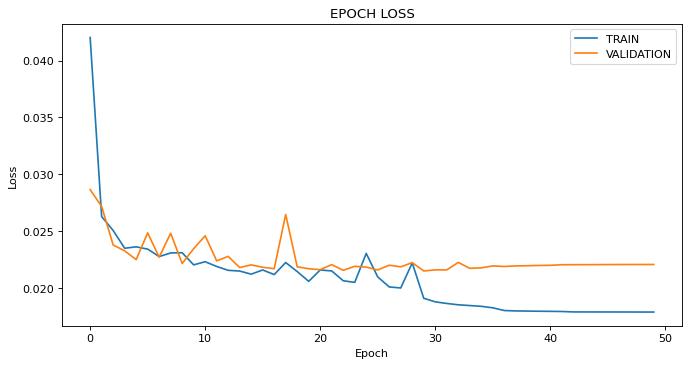

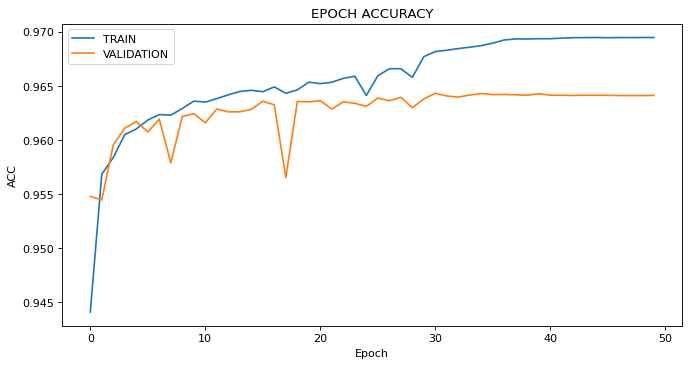

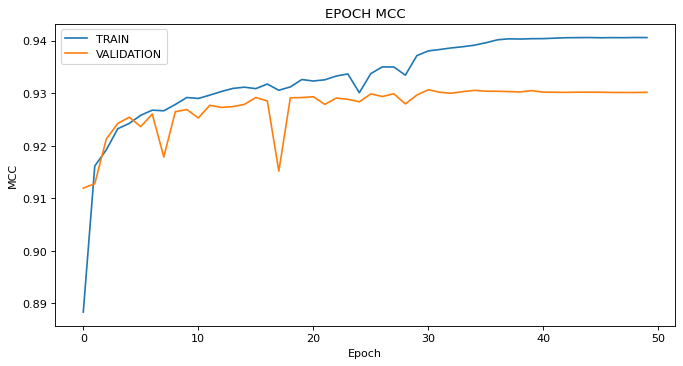

In [57]:
trainer.plot()

In [63]:
###TESTING ON THE TEST SET
model = NeuralClassifier_CV()
use_cuda = True
if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available!  Testing on GPU ...')
else:
    print('CUDA is not available.  Testing on CPU ...')
    
state = torch.load(os.getcwd()+'/DL_SAVES/NeuralClassifier_CV_lr_0.001_run_3002_epoch_40.pt')
model.load_state_dict(state)

print("\nTEST SET_____________________")
test_dataloader = DataLoader(test_set,
                            batch_size=8192,
                            shuffle=False)

pred, label = get_accuracy_d(model, test_dataloader) #loss_eval, acc_eval, mcc_eval,
pred = list(itertools.chain(*pred))
label = list(itertools.chain(*label))

target_names = ['low', 'med', 'high']
print(classification_report(label, pred, target_names=target_names))
print("MCC: ", matthews_corrcoef(label, pred))
print(confusion_matrix(label, pred))

print("\nTRAIN SET_____________________")
test_dataloader = DataLoader(train_set,
                            batch_size=8192,
                            shuffle=False)

pred, label = get_accuracy_d(model, test_dataloader) #loss_eval, acc_eval, mcc_eval,
pred = list(itertools.chain(*pred))
label = list(itertools.chain(*label))

target_names = ['low', 'med', 'high']
print(classification_report(label, pred, target_names=target_names))
print("MCC: ", matthews_corrcoef(label, pred))
print(confusion_matrix(label, pred))

print("\nVAL SET_____________________")
test_dataloader = DataLoader(val_set,
                            batch_size=8192,
                            shuffle=False)

pred, label = get_accuracy_d(model, test_dataloader) #loss_eval, acc_eval, mcc_eval,
pred = list(itertools.chain(*pred))
label = list(itertools.chain(*label))

target_names = ['low', 'med', 'high']
print(classification_report(label, pred, target_names=target_names))
print("MCC: ", matthews_corrcoef(label, pred))
print(confusion_matrix(label, pred))

CUDA is available!  Testing on GPU ...

TEST SET_____________________
              precision    recall  f1-score   support

         low       1.00      1.00      1.00    120000
         med       0.94      0.96      0.95     70000
        high       0.69      0.55      0.61     10000

    accuracy                           0.96    200000
   macro avg       0.87      0.84      0.85    200000
weighted avg       0.96      0.96      0.96    200000

MCC:  0.9312429760726509
[[119989     10      1]
 [    52  67443   2505]
 [    44   4447   5509]]

TRAIN SET_____________________
              precision    recall  f1-score   support

         low       1.00      1.00      1.00    384000
         med       0.94      0.97      0.96    224000
        high       0.74      0.60      0.66     32000

    accuracy                           0.97    640000
   macro avg       0.90      0.86      0.87    640000
weighted avg       0.97      0.97      0.97    640000

MCC:  0.9404354743547534
[[383991     

In [89]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
pytorch_total_params

742931

## FOLD 2

In [64]:
dict_params = {'batch_size': 1024,
              'run': 3002_2,
              'is_weights': False,
              'epochs': 50,
              'save_every': 5,
              'lr': 0.001,
              'device': 0,
              'model': NeuralClassifier_CV(),
              'gamma': 2}

X_train, X_val, X_test, y_train, y_val, y_test = fold_dict['fold_2']

y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

trainer = run_dl_fold(X_train, y_train, X_val, y_val, dict_params)

---------------------------------------------------------------------------
GPU0 Epoch 0
Train Loss: 0.04880057 | Val Loss: 0.02698940
Train ACC: 0.93564063 | Val ACC: 0.95613750
Train MCC: 0.87856564 | Val MCC: 0.91465988
Epoch 0 | Training checkpoint
---------------------------------------------------------------------------
GPU0 Epoch 1
Train Loss: 0.02642172 | Val Loss: 0.02597329
Train ACC: 0.95707813 | Val ACC: 0.95708750
Train MCC: 0.91657123 | Val MCC: 0.91664964
---------------------------------------------------------------------------
GPU0 Epoch 2
Train Loss: 0.02495392 | Val Loss: 0.02322474
Train ACC: 0.95889687 | Val ACC: 0.96046875
Train MCC: 0.92005143 | Val MCC: 0.92313626
---------------------------------------------------------------------------
GPU0 Epoch 3
Train Loss: 0.02374640 | Val Loss: 0.02293820
Train ACC: 0.96095937 | Val ACC: 0.96225000
Train MCC: 0.92405353 | Val MCC: 0.92647703
---------------------------------------------------------------------------
GP

---------------------------------------------------------------------------
GPU0 Epoch 36
Train Loss: 0.01741253 | Val Loss: 0.02276386
Train ACC: 0.96980312 | Val ACC: 0.96454375
Train MCC: 0.94126275 | Val MCC: 0.93110633
---------------------------------------------------------------------------
GPU0 Epoch 37
Train Loss: 0.01731048 | Val Loss: 0.02357338
Train ACC: 0.97001563 | Val ACC: 0.96449375
Train MCC: 0.94169610 | Val MCC: 0.93100883
---------------------------------------------------------------------------
GPU0 Epoch 38
Train Loss: 0.01718059 | Val Loss: 0.02382053
Train ACC: 0.97023750 | Val ACC: 0.96455000
Train MCC: 0.94211590 | Val MCC: 0.93112674
---------------------------------------------------------------------------
GPU0 Epoch 39
Train Loss: 0.01689917 | Val Loss: 0.02410805
Train ACC: 0.97054219 | Val ACC: 0.96441250
Train MCC: 0.94269086 | Val MCC: 0.93089913
---------------------------------------------------------------------------
GPU0 Epoch 40
Train Loss: 0.

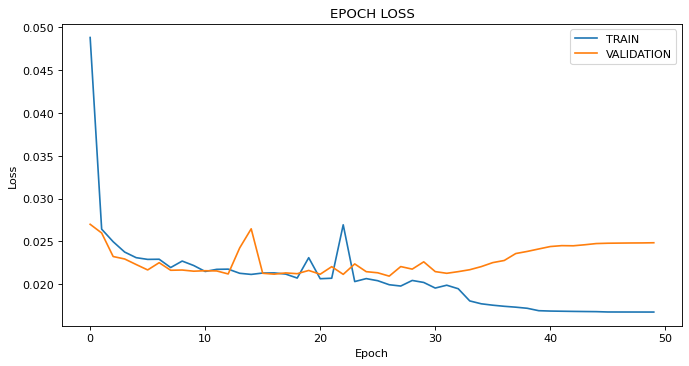

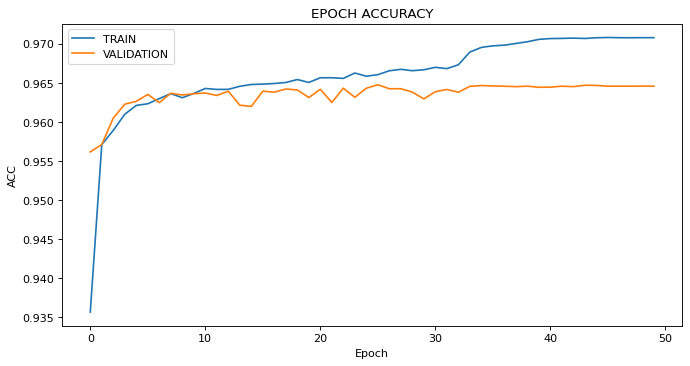

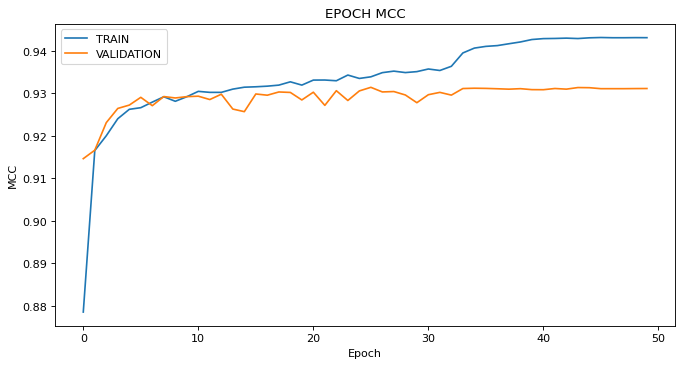

In [65]:
trainer.plot()

In [67]:
###TESTING ON THE TEST SET
model = NeuralClassifier_CV()
use_cuda = True
if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available!  Testing on GPU ...')
else:
    print('CUDA is not available.  Testing on CPU ...')
    
state = torch.load(os.getcwd()+'/DL_SAVES/NeuralClassifier_CV_lr_0.001_run_30022_epoch_40.pt')
model.load_state_dict(state)

print("\nTEST SET_____________________")
test_dataloader = DataLoader(test_set,
                            batch_size=8192,
                            shuffle=False)

pred, label = get_accuracy_d(model, test_dataloader) #loss_eval, acc_eval, mcc_eval,
pred = list(itertools.chain(*pred))
label = list(itertools.chain(*label))

target_names = ['low', 'med', 'high']
print(classification_report(label, pred, target_names=target_names))
print("MCC: ", matthews_corrcoef(label, pred))
print(confusion_matrix(label, pred))

print("\nTRAIN SET_____________________")
test_dataloader = DataLoader(train_set,
                            batch_size=8192,
                            shuffle=False)

pred, label = get_accuracy_d(model, test_dataloader) #loss_eval, acc_eval, mcc_eval,
pred = list(itertools.chain(*pred))
label = list(itertools.chain(*label))

target_names = ['low', 'med', 'high']
print(classification_report(label, pred, target_names=target_names))
print("MCC: ", matthews_corrcoef(label, pred))
print(confusion_matrix(label, pred))

print("\nVAL SET_____________________")
test_dataloader = DataLoader(val_set,
                            batch_size=8192,
                            shuffle=False)

pred, label = get_accuracy_d(model, test_dataloader) #loss_eval, acc_eval, mcc_eval,
pred = list(itertools.chain(*pred))
label = list(itertools.chain(*label))

target_names = ['low', 'med', 'high']
print(classification_report(label, pred, target_names=target_names))
print("MCC: ", matthews_corrcoef(label, pred))
print(confusion_matrix(label, pred))

CUDA is available!  Testing on GPU ...

TEST SET_____________________
              precision    recall  f1-score   support

         low       1.00      1.00      1.00    120000
         med       0.95      0.97      0.96     70000
        high       0.74      0.61      0.67     10000

    accuracy                           0.97    200000
   macro avg       0.89      0.86      0.87    200000
weighted avg       0.97      0.97      0.97    200000

MCC:  0.9406524991686797
[[119993      4      3]
 [    34  67818   2148]
 [    37   3870   6093]]

TRAIN SET_____________________
              precision    recall  f1-score   support

         low       1.00      1.00      1.00    384000
         med       0.94      0.97      0.96    224000
        high       0.73      0.60      0.66     32000

    accuracy                           0.97    640000
   macro avg       0.89      0.86      0.87    640000
weighted avg       0.97      0.97      0.97    640000

MCC:  0.9385298605071398
[[383982     

### Experimenting with gamma

gamma = [0, 0.5, 1, 2, 10]

In [79]:
dict_params = {'batch_size': 1024,
              'run': '30022_gamma_0',
              'is_weights': False,
              'epochs': 50,
              'save_every': 5,
              'lr': 0.001,
              'device': 0,
              'model': NeuralClassifier_CV(),
              'gamma': 0}

X_train, X_val, X_test, y_train, y_val, y_test = fold_dict['fold_2']

y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

trainer = run_dl_fold(X_train, y_train, X_val, y_val, dict_params)

---------------------------------------------------------------------------
GPU0 Epoch 0
Train Loss: 0.14341411 | Val Loss: 0.09944515
Train ACC: 0.94334844 | Val ACC: 0.95591875
Train MCC: 0.88740756 | Val MCC: 0.91413245
Epoch 0 | Training checkpoint
---------------------------------------------------------------------------
GPU0 Epoch 1
Train Loss: 0.09677779 | Val Loss: 0.09469025
Train ACC: 0.95718906 | Val ACC: 0.95718750
Train MCC: 0.91674020 | Val MCC: 0.91694715
---------------------------------------------------------------------------
GPU0 Epoch 2
Train Loss: 0.09173302 | Val Loss: 0.08718359
Train ACC: 0.95869844 | Val ACC: 0.96030625
Train MCC: 0.91970899 | Val MCC: 0.92270399
---------------------------------------------------------------------------
GPU0 Epoch 3
Train Loss: 0.08687904 | Val Loss: 0.08459548
Train ACC: 0.96081250 | Val ACC: 0.96181875
Train MCC: 0.92379931 | Val MCC: 0.92583490
---------------------------------------------------------------------------
GP

---------------------------------------------------------------------------
GPU0 Epoch 36
Train Loss: 0.06572783 | Val Loss: 0.08210658
Train ACC: 0.97077031 | Val ACC: 0.96477500
Train MCC: 0.94314967 | Val MCC: 0.93158908
---------------------------------------------------------------------------
GPU0 Epoch 37
Train Loss: 0.06571807 | Val Loss: 0.08212977
Train ACC: 0.97077187 | Val ACC: 0.96477500
Train MCC: 0.94315265 | Val MCC: 0.93158759
---------------------------------------------------------------------------
GPU0 Epoch 38
Train Loss: 0.06571076 | Val Loss: 0.08215365
Train ACC: 0.97079063 | Val ACC: 0.96480000
Train MCC: 0.94318689 | Val MCC: 0.93163720
---------------------------------------------------------------------------
GPU0 Epoch 39
Train Loss: 0.06570466 | Val Loss: 0.08215418
Train ACC: 0.97079844 | Val ACC: 0.96479375
Train MCC: 0.94320837 | Val MCC: 0.93162473
---------------------------------------------------------------------------
GPU0 Epoch 40
Train Loss: 0.

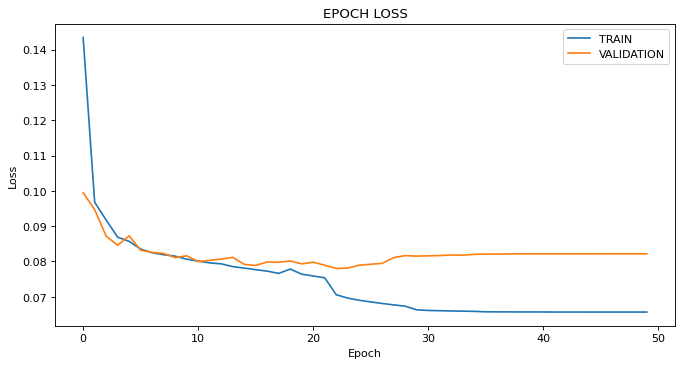

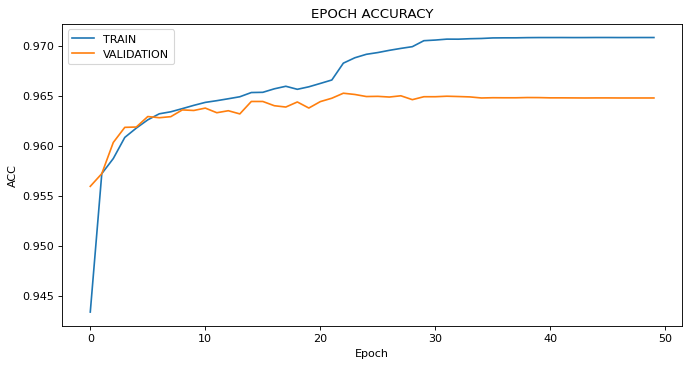

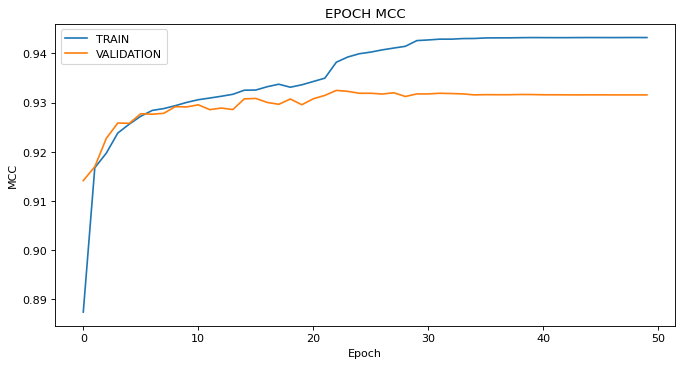

In [80]:
trainer.plot()

In [81]:
###TESTING ON THE TEST SET
model = NeuralClassifier_CV()
use_cuda = True
if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available!  Testing on GPU ...')
else:
    print('CUDA is not available.  Testing on CPU ...')
    
state = torch.load(os.getcwd()+'/DL_SAVES/NeuralClassifier_CV_lr_0.001_run_30022_gamma_0_epoch_40.pt')
model.load_state_dict(state)

print("\nTEST SET_____________________")
test_dataloader = DataLoader(test_set,
                            batch_size=8192,
                            shuffle=False)

pred, label = get_accuracy_d(model, test_dataloader) #loss_eval, acc_eval, mcc_eval,
pred = list(itertools.chain(*pred))
label = list(itertools.chain(*label))

target_names = ['low', 'med', 'high']
print(classification_report(label, pred, target_names=target_names))
print("MCC: ", matthews_corrcoef(label, pred))
print(confusion_matrix(label, pred))

print("\nTRAIN SET_____________________")
test_dataloader = DataLoader(train_set,
                            batch_size=8192,
                            shuffle=False)

pred, label = get_accuracy_d(model, test_dataloader) #loss_eval, acc_eval, mcc_eval,
pred = list(itertools.chain(*pred))
label = list(itertools.chain(*label))

target_names = ['low', 'med', 'high']
print(classification_report(label, pred, target_names=target_names))
print("MCC: ", matthews_corrcoef(label, pred))
print(confusion_matrix(label, pred))

print("\nVAL SET_____________________")
test_dataloader = DataLoader(val_set,
                            batch_size=8192,
                            shuffle=False)

pred, label = get_accuracy_d(model, test_dataloader) #loss_eval, acc_eval, mcc_eval,
pred = list(itertools.chain(*pred))
label = list(itertools.chain(*label))

target_names = ['low', 'med', 'high']
print(classification_report(label, pred, target_names=target_names))
print("MCC: ", matthews_corrcoef(label, pred))
print(confusion_matrix(label, pred))

CUDA is available!  Testing on GPU ...

TEST SET_____________________
              precision    recall  f1-score   support

         low       1.00      1.00      1.00    120000
         med       0.94      0.97      0.96     70000
        high       0.75      0.60      0.67     10000

    accuracy                           0.97    200000
   macro avg       0.90      0.86      0.87    200000
weighted avg       0.97      0.97      0.97    200000

MCC:  0.9412323682866041
[[119996      4      0]
 [    41  68010   1949]
 [    39   4004   5957]]

TRAIN SET_____________________
              precision    recall  f1-score   support

         low       1.00      1.00      1.00    384000
         med       0.94      0.97      0.96    224000
        high       0.74      0.59      0.65     32000

    accuracy                           0.97    640000
   macro avg       0.89      0.85      0.87    640000
weighted avg       0.97      0.97      0.97    640000

MCC:  0.9390961826892198
[[383979     

In [84]:
dict_params = {'batch_size': 1024,
              'run': '30022_gamma_10',
              'is_weights': False,
              'epochs': 50,
              'save_every': 5,
              'lr': 0.001,
              'device': 0,
              'model': NeuralClassifier_CV(),
              'gamma': 10}

X_train, X_val, X_test, y_train, y_val, y_test = fold_dict['fold_2']

y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

trainer = run_dl_fold(X_train, y_train, X_val, y_val, dict_params)

---------------------------------------------------------------------------
GPU0 Epoch 0
Train Loss: 0.00126458 | Val Loss: 0.00025098
Train ACC: 0.93065625 | Val ACC: 0.94911250
Train MCC: 0.87976005 | Val MCC: 0.90309240
Epoch 0 | Training checkpoint
---------------------------------------------------------------------------
GPU0 Epoch 1
Train Loss: 0.00032648 | Val Loss: 0.00028095
Train ACC: 0.94861406 | Val ACC: 0.94892500
Train MCC: 0.90196452 | Val MCC: 0.90259501
---------------------------------------------------------------------------
GPU0 Epoch 2
Train Loss: 0.00030972 | Val Loss: 0.00033884
Train ACC: 0.94806250 | Val ACC: 0.94458125
Train MCC: 0.90086155 | Val MCC: 0.89338761
---------------------------------------------------------------------------
GPU0 Epoch 3
Train Loss: 0.00032344 | Val Loss: 0.00051400
Train ACC: 0.94798125 | Val ACC: 0.94626250
Train MCC: 0.90067024 | Val MCC: 0.89655309
---------------------------------------------------------------------------
GP

---------------------------------------------------------------------------
GPU0 Epoch 36
Train Loss: 0.00012515 | Val Loss: 0.00012743
Train ACC: 0.96360469 | Val ACC: 0.96301875
Train MCC: 0.92918902 | Val MCC: 0.92810582
---------------------------------------------------------------------------
GPU0 Epoch 37
Train Loss: 0.00012492 | Val Loss: 0.00012754
Train ACC: 0.96359375 | Val ACC: 0.96294375
Train MCC: 0.92914379 | Val MCC: 0.92795269
---------------------------------------------------------------------------
GPU0 Epoch 38
Train Loss: 0.00012492 | Val Loss: 0.00012831
Train ACC: 0.96356875 | Val ACC: 0.96296250
Train MCC: 0.92910679 | Val MCC: 0.92799299
---------------------------------------------------------------------------
GPU0 Epoch 39
Train Loss: 0.00012449 | Val Loss: 0.00012696
Train ACC: 0.96347500 | Val ACC: 0.96286875
Train MCC: 0.92890736 | Val MCC: 0.92781371
---------------------------------------------------------------------------
GPU0 Epoch 40
Train Loss: 0.

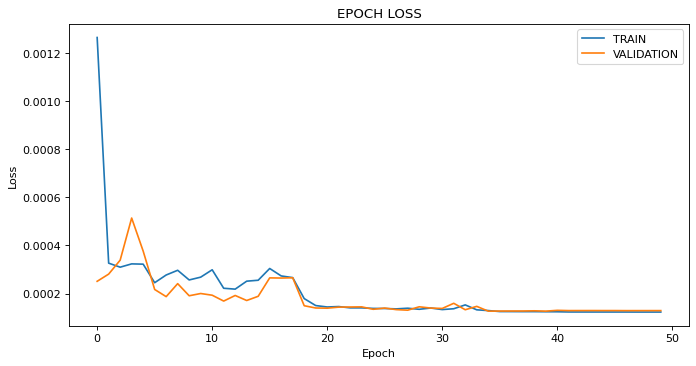

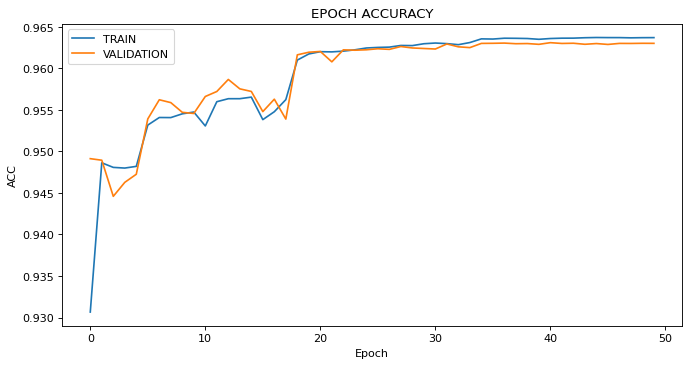

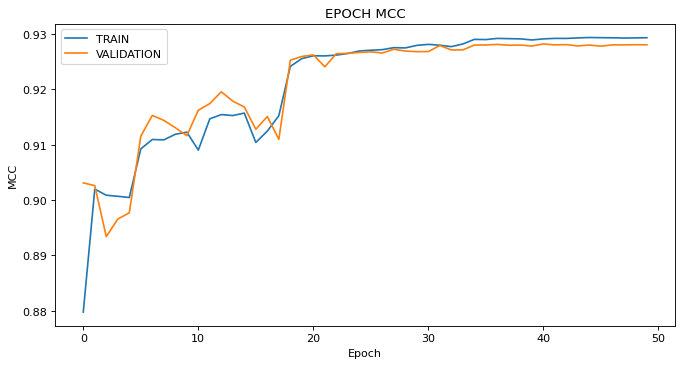

In [85]:
trainer.plot()

In [86]:
###TESTING ON THE TEST SET
model = NeuralClassifier_CV()
use_cuda = True
if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available!  Testing on GPU ...')
else:
    print('CUDA is not available.  Testing on CPU ...')
    
state = torch.load(os.getcwd()+'/DL_SAVES/NeuralClassifier_CV_lr_0.001_run_30022_gamma_10_epoch_40.pt')
model.load_state_dict(state)

print("\nTEST SET_____________________")
test_dataloader = DataLoader(test_set,
                            batch_size=8192,
                            shuffle=False)

pred, label = get_accuracy_d(model, test_dataloader) #loss_eval, acc_eval, mcc_eval,
pred = list(itertools.chain(*pred))
label = list(itertools.chain(*label))

target_names = ['low', 'med', 'high']
print(classification_report(label, pred, target_names=target_names))
print("MCC: ", matthews_corrcoef(label, pred))
print(confusion_matrix(label, pred))

print("\nTRAIN SET_____________________")
test_dataloader = DataLoader(train_set,
                            batch_size=8192,
                            shuffle=False)

pred, label = get_accuracy_d(model, test_dataloader) #loss_eval, acc_eval, mcc_eval,
pred = list(itertools.chain(*pred))
label = list(itertools.chain(*label))

target_names = ['low', 'med', 'high']
print(classification_report(label, pred, target_names=target_names))
print("MCC: ", matthews_corrcoef(label, pred))
print(confusion_matrix(label, pred))

print("\nVAL SET_____________________")
test_dataloader = DataLoader(val_set,
                            batch_size=8192,
                            shuffle=False)

pred, label = get_accuracy_d(model, test_dataloader) #loss_eval, acc_eval, mcc_eval,
pred = list(itertools.chain(*pred))
label = list(itertools.chain(*label))

target_names = ['low', 'med', 'high']
print(classification_report(label, pred, target_names=target_names))
print("MCC: ", matthews_corrcoef(label, pred))
print(confusion_matrix(label, pred))

CUDA is available!  Testing on GPU ...

TEST SET_____________________
              precision    recall  f1-score   support

         low       1.00      1.00      1.00    120000
         med       0.93      0.96      0.95     70000
        high       0.68      0.52      0.59     10000

    accuracy                           0.96    200000
   macro avg       0.87      0.83      0.85    200000
weighted avg       0.96      0.96      0.96    200000

MCC:  0.929315304612009
[[119993      6      1]
 [    34  67516   2450]
 [    37   4729   5234]]

TRAIN SET_____________________
              precision    recall  f1-score   support

         low       1.00      1.00      1.00    384000
         med       0.93      0.96      0.95    224000
        high       0.68      0.52      0.59     32000

    accuracy                           0.96    640000
   macro avg       0.87      0.83      0.85    640000
weighted avg       0.96      0.96      0.96    640000

MCC:  0.9287726334460763
[[383959     3

## FOLD 3

In [68]:
dict_params = {'batch_size': 1024,
              'run': 3002_3,
              'is_weights': False,
              'epochs': 50,
              'save_every': 5,
              'lr': 0.001,
              'device': 0,
              'model': NeuralClassifier_CV(),
              'gamma': 2}

X_train, X_val, X_test, y_train, y_val, y_test = fold_dict['fold_3']

y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

trainer = run_dl_fold(X_train, y_train, X_val, y_val, dict_params)

---------------------------------------------------------------------------
GPU0 Epoch 0
Train Loss: 0.04858147 | Val Loss: 0.02605636
Train ACC: 0.92975781 | Val ACC: 0.95696250
Train MCC: 0.88406148 | Val MCC: 0.91643715
Epoch 0 | Training checkpoint
---------------------------------------------------------------------------
GPU0 Epoch 1
Train Loss: 0.02662373 | Val Loss: 0.02577703
Train ACC: 0.95679844 | Val ACC: 0.95790000
Train MCC: 0.91605617 | Val MCC: 0.91815477
---------------------------------------------------------------------------
GPU0 Epoch 2
Train Loss: 0.02559969 | Val Loss: 0.02350579
Train ACC: 0.95791094 | Val ACC: 0.95991250
Train MCC: 0.91816319 | Val MCC: 0.92192611
---------------------------------------------------------------------------
GPU0 Epoch 3
Train Loss: 0.02378212 | Val Loss: 0.02246474
Train ACC: 0.96037812 | Val ACC: 0.96183125
Train MCC: 0.92297780 | Val MCC: 0.92569750
---------------------------------------------------------------------------
GP

---------------------------------------------------------------------------
GPU0 Epoch 36
Train Loss: 0.01698592 | Val Loss: 0.02338582
Train ACC: 0.97026406 | Val ACC: 0.96416250
Train MCC: 0.94216108 | Val MCC: 0.93017549
---------------------------------------------------------------------------
GPU0 Epoch 37
Train Loss: 0.01696281 | Val Loss: 0.02348478
Train ACC: 0.97028750 | Val ACC: 0.96425000
Train MCC: 0.94220143 | Val MCC: 0.93034065
---------------------------------------------------------------------------
GPU0 Epoch 38
Train Loss: 0.01694285 | Val Loss: 0.02358724
Train ACC: 0.97037500 | Val ACC: 0.96419375
Train MCC: 0.94237089 | Val MCC: 0.93023392
---------------------------------------------------------------------------
GPU0 Epoch 39
Train Loss: 0.01692294 | Val Loss: 0.02365996
Train ACC: 0.97035938 | Val ACC: 0.96411250
Train MCC: 0.94235277 | Val MCC: 0.93007602
---------------------------------------------------------------------------
GPU0 Epoch 40
Train Loss: 0.

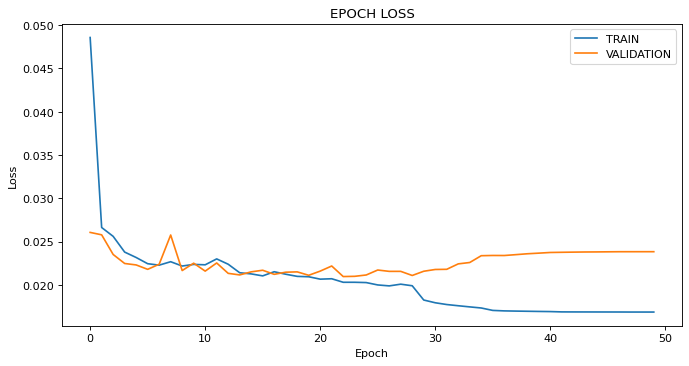

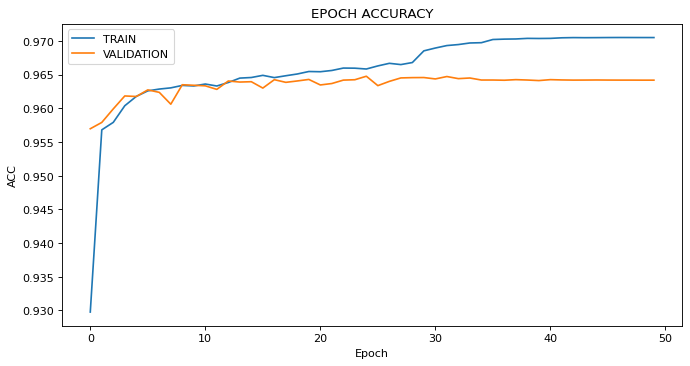

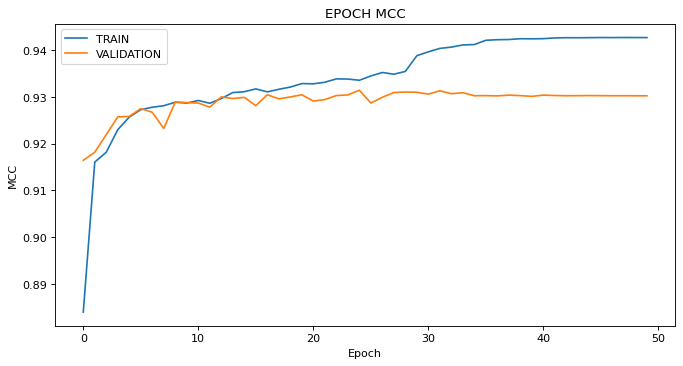

In [69]:
trainer.plot()

In [70]:
###TESTING ON THE TEST SET
model = NeuralClassifier_CV()
use_cuda = True
if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available!  Testing on GPU ...')
else:
    print('CUDA is not available.  Testing on CPU ...')
    
state = torch.load(os.getcwd()+'/DL_SAVES/NeuralClassifier_CV_lr_0.001_run_30023_epoch_40.pt')
model.load_state_dict(state)

print("\nTEST SET_____________________")
test_dataloader = DataLoader(test_set,
                            batch_size=8192,
                            shuffle=False)

pred, label = get_accuracy_d(model, test_dataloader) #loss_eval, acc_eval, mcc_eval,
pred = list(itertools.chain(*pred))
label = list(itertools.chain(*label))

target_names = ['low', 'med', 'high']
print(classification_report(label, pred, target_names=target_names))
print("MCC: ", matthews_corrcoef(label, pred))
print(confusion_matrix(label, pred))

print("\nTRAIN SET_____________________")
test_dataloader = DataLoader(train_set,
                            batch_size=8192,
                            shuffle=False)

pred, label = get_accuracy_d(model, test_dataloader) #loss_eval, acc_eval, mcc_eval,
pred = list(itertools.chain(*pred))
label = list(itertools.chain(*label))

target_names = ['low', 'med', 'high']
print(classification_report(label, pred, target_names=target_names))
print("MCC: ", matthews_corrcoef(label, pred))
print(confusion_matrix(label, pred))

print("\nVAL SET_____________________")
test_dataloader = DataLoader(val_set,
                            batch_size=8192,
                            shuffle=False)

pred, label = get_accuracy_d(model, test_dataloader) #loss_eval, acc_eval, mcc_eval,
pred = list(itertools.chain(*pred))
label = list(itertools.chain(*label))

target_names = ['low', 'med', 'high']
print(classification_report(label, pred, target_names=target_names))
print("MCC: ", matthews_corrcoef(label, pred))
print(confusion_matrix(label, pred))

CUDA is available!  Testing on GPU ...

TEST SET_____________________
              precision    recall  f1-score   support

         low       1.00      1.00      1.00    120000
         med       0.94      0.97      0.96     70000
        high       0.74      0.60      0.66     10000

    accuracy                           0.97    200000
   macro avg       0.89      0.85      0.87    200000
weighted avg       0.97      0.97      0.97    200000

MCC:  0.9396190174918264
[[119993      5      2]
 [    31  67853   2116]
 [    39   4009   5952]]

TRAIN SET_____________________
              precision    recall  f1-score   support

         low       1.00      1.00      1.00    384000
         med       0.94      0.97      0.96    224000
        high       0.73      0.59      0.65     32000

    accuracy                           0.97    640000
   macro avg       0.89      0.85      0.87    640000
weighted avg       0.97      0.97      0.97    640000

MCC:  0.9379804664173493
[[383958     

## FOLD 4

In [71]:
dict_params = {'batch_size': 1024,
              'run': 3002_4,
              'is_weights': False,
              'epochs': 50,
              'save_every': 5,
              'lr': 0.001,
              'device': 0,
              'model': NeuralClassifier_CV(),
              'gamma': 2}

X_train, X_val, X_test, y_train, y_val, y_test = fold_dict['fold_4']

y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

trainer = run_dl_fold(X_train, y_train, X_val, y_val, dict_params)

---------------------------------------------------------------------------
GPU0 Epoch 0
Train Loss: 0.05851453 | Val Loss: 0.02558477
Train ACC: 0.92975000 | Val ACC: 0.95774375
Train MCC: 0.86729655 | Val MCC: 0.91768167
Epoch 0 | Training checkpoint
---------------------------------------------------------------------------
GPU0 Epoch 1
Train Loss: 0.02589225 | Val Loss: 0.02438571
Train ACC: 0.95743750 | Val ACC: 0.95892500
Train MCC: 0.91725623 | Val MCC: 0.92012409
---------------------------------------------------------------------------
GPU0 Epoch 2
Train Loss: 0.02485422 | Val Loss: 0.02353588
Train ACC: 0.95916406 | Val ACC: 0.95906250
Train MCC: 0.92058762 | Val MCC: 0.92055632
---------------------------------------------------------------------------
GPU0 Epoch 3
Train Loss: 0.02363674 | Val Loss: 0.02338084
Train ACC: 0.96098750 | Val ACC: 0.96175000
Train MCC: 0.92413101 | Val MCC: 0.92548439
---------------------------------------------------------------------------
GP

---------------------------------------------------------------------------
GPU0 Epoch 36
Train Loss: 0.01819682 | Val Loss: 0.02102090
Train ACC: 0.96836094 | Val ACC: 0.96496250
Train MCC: 0.93843217 | Val MCC: 0.93193448
---------------------------------------------------------------------------
GPU0 Epoch 37
Train Loss: 0.01819419 | Val Loss: 0.02102821
Train ACC: 0.96834844 | Val ACC: 0.96493750
Train MCC: 0.93843443 | Val MCC: 0.93188682
---------------------------------------------------------------------------
GPU0 Epoch 38
Train Loss: 0.01819281 | Val Loss: 0.02103416
Train ACC: 0.96837812 | Val ACC: 0.96491250
Train MCC: 0.93848611 | Val MCC: 0.93184018
---------------------------------------------------------------------------
GPU0 Epoch 39
Train Loss: 0.01819153 | Val Loss: 0.02103705
Train ACC: 0.96838750 | Val ACC: 0.96494375
Train MCC: 0.93848451 | Val MCC: 0.93190225
---------------------------------------------------------------------------
GPU0 Epoch 40
Train Loss: 0.

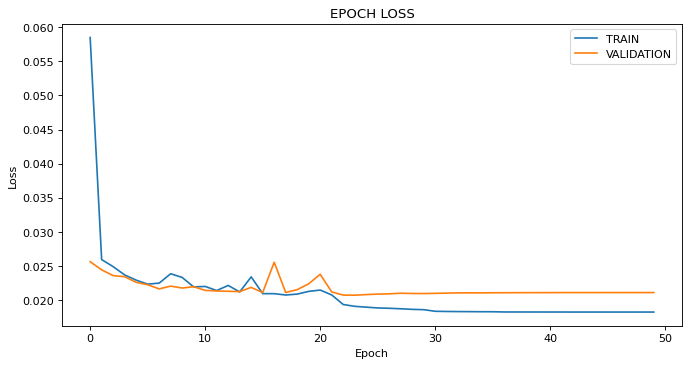

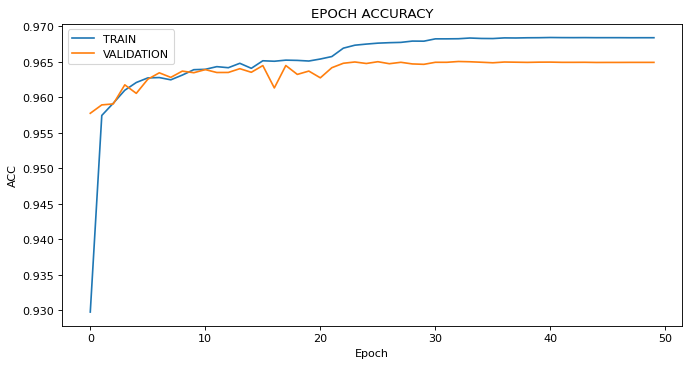

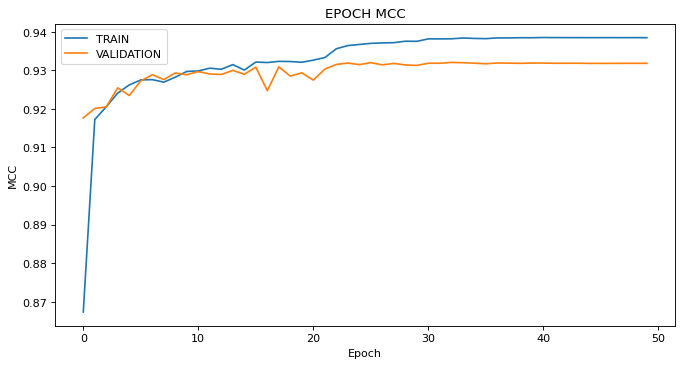

In [72]:
trainer.plot()

In [73]:
###TESTING ON THE TEST SET
model = NeuralClassifier_CV()
use_cuda = True
if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available!  Testing on GPU ...')
else:
    print('CUDA is not available.  Testing on CPU ...')
    
state = torch.load(os.getcwd()+'/DL_SAVES/NeuralClassifier_CV_lr_0.001_run_30024_epoch_40.pt')
model.load_state_dict(state)

print("\nTEST SET_____________________")
test_dataloader = DataLoader(test_set,
                            batch_size=8192,
                            shuffle=False)

pred, label = get_accuracy_d(model, test_dataloader) #loss_eval, acc_eval, mcc_eval,
pred = list(itertools.chain(*pred))
label = list(itertools.chain(*label))

target_names = ['low', 'med', 'high']
print(classification_report(label, pred, target_names=target_names))
print("MCC: ", matthews_corrcoef(label, pred))
print(confusion_matrix(label, pred))

print("\nTRAIN SET_____________________")
test_dataloader = DataLoader(train_set,
                            batch_size=8192,
                            shuffle=False)

pred, label = get_accuracy_d(model, test_dataloader) #loss_eval, acc_eval, mcc_eval,
pred = list(itertools.chain(*pred))
label = list(itertools.chain(*label))

target_names = ['low', 'med', 'high']
print(classification_report(label, pred, target_names=target_names))
print("MCC: ", matthews_corrcoef(label, pred))
print(confusion_matrix(label, pred))

print("\nVAL SET_____________________")
test_dataloader = DataLoader(val_set,
                            batch_size=8192,
                            shuffle=False)

pred, label = get_accuracy_d(model, test_dataloader) #loss_eval, acc_eval, mcc_eval,
pred = list(itertools.chain(*pred))
label = list(itertools.chain(*label))

target_names = ['low', 'med', 'high']
print(classification_report(label, pred, target_names=target_names))
print("MCC: ", matthews_corrcoef(label, pred))
print(confusion_matrix(label, pred))

CUDA is available!  Testing on GPU ...

TEST SET_____________________
              precision    recall  f1-score   support

         low       1.00      1.00      1.00    120000
         med       0.94      0.97      0.95     70000
        high       0.72      0.58      0.65     10000

    accuracy                           0.97    200000
   macro avg       0.89      0.85      0.87    200000
weighted avg       0.97      0.97      0.97    200000

MCC:  0.9371770716876233
[[119997      2      1]
 [    29  67709   2262]
 [    37   4121   5842]]

TRAIN SET_____________________
              precision    recall  f1-score   support

         low       1.00      1.00      1.00    384000
         med       0.94      0.97      0.95    224000
        high       0.71      0.58      0.64     32000

    accuracy                           0.97    640000
   macro avg       0.88      0.85      0.86    640000
weighted avg       0.96      0.97      0.97    640000

MCC:  0.9357764540923612
[[383965     

## FOLD 5

In [74]:
dict_params = {'batch_size': 1024,
              'run': 3002_5,
              'is_weights': False,
              'epochs': 50,
              'save_every': 5,
              'lr': 0.001,
              'device': 0,
              'model': NeuralClassifier_CV(),
              'gamma': 2}

X_train, X_val, X_test, y_train, y_val, y_test = fold_dict['fold_5']

y_train = y_train.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

trainer = run_dl_fold(X_train, y_train, X_val, y_val, dict_params)

---------------------------------------------------------------------------
GPU0 Epoch 0
Train Loss: 0.04422562 | Val Loss: 0.02683044
Train ACC: 0.93994062 | Val ACC: 0.95609375
Train MCC: 0.88140340 | Val MCC: 0.91446211
Epoch 0 | Training checkpoint
---------------------------------------------------------------------------
GPU0 Epoch 1
Train Loss: 0.02730086 | Val Loss: 0.03001753
Train ACC: 0.95592031 | Val ACC: 0.95354375
Train MCC: 0.91438628 | Val MCC: 0.90968431
---------------------------------------------------------------------------
GPU0 Epoch 2
Train Loss: 0.02589304 | Val Loss: 0.02662448
Train ACC: 0.95700781 | Val ACC: 0.95704375
Train MCC: 0.91649310 | Val MCC: 0.91678902
---------------------------------------------------------------------------
GPU0 Epoch 3
Train Loss: 0.02492259 | Val Loss: 0.02387266
Train ACC: 0.95840156 | Val ACC: 0.95980625
Train MCC: 0.91917538 | Val MCC: 0.92184397
---------------------------------------------------------------------------
GP

---------------------------------------------------------------------------
GPU0 Epoch 36
Train Loss: 0.01797792 | Val Loss: 0.02136722
Train ACC: 0.96890469 | Val ACC: 0.96479375
Train MCC: 0.93950884 | Val MCC: 0.93151935
---------------------------------------------------------------------------
GPU0 Epoch 37
Train Loss: 0.01796804 | Val Loss: 0.02138536
Train ACC: 0.96894531 | Val ACC: 0.96465625
Train MCC: 0.93959771 | Val MCC: 0.93124952
---------------------------------------------------------------------------
GPU0 Epoch 38
Train Loss: 0.01795434 | Val Loss: 0.02142200
Train ACC: 0.96891562 | Val ACC: 0.96481875
Train MCC: 0.93954110 | Val MCC: 0.93156792
---------------------------------------------------------------------------
GPU0 Epoch 39
Train Loss: 0.01792761 | Val Loss: 0.02142568
Train ACC: 0.96900469 | Val ACC: 0.96481250
Train MCC: 0.93970610 | Val MCC: 0.93155438
---------------------------------------------------------------------------
GPU0 Epoch 40
Train Loss: 0.

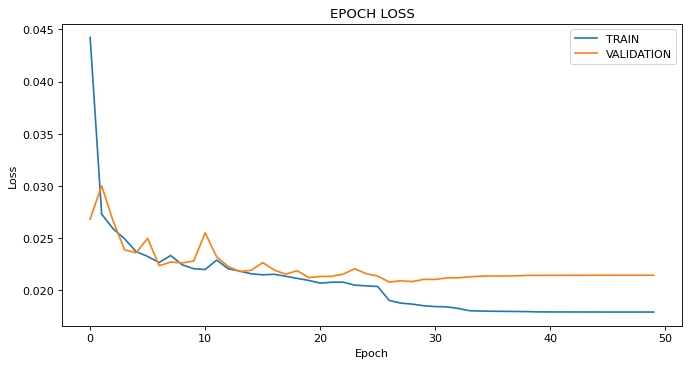

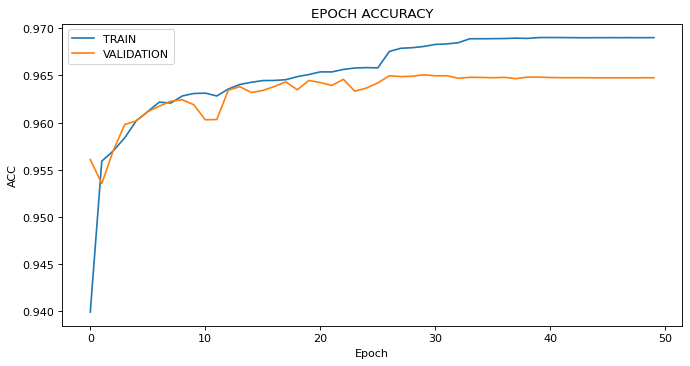

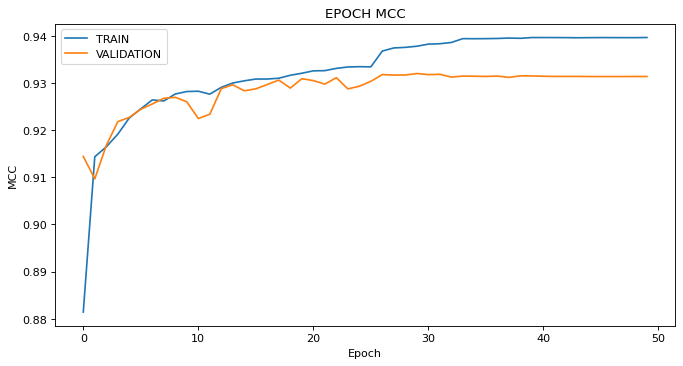

In [75]:
trainer.plot()

In [78]:
###TESTING ON THE TEST SET
model = NeuralClassifier_CV()
use_cuda = True
if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available!  Testing on GPU ...')
else:
    print('CUDA is not available.  Testing on CPU ...')
    
state = torch.load(os.getcwd()+'/DL_SAVES/NeuralClassifier_CV_lr_0.001_run_30025_epoch_40.pt')
model.load_state_dict(state)

print("\nTEST SET_____________________")
test_dataloader = DataLoader(test_set,
                            batch_size=8192,
                            shuffle=False)

pred, label = get_accuracy_d(model, test_dataloader) #loss_eval, acc_eval, mcc_eval,
pred = list(itertools.chain(*pred))
label = list(itertools.chain(*label))

target_names = ['low', 'med', 'high']
print(classification_report(label, pred, target_names=target_names))
print("MCC: ", matthews_corrcoef(label, pred))
print(confusion_matrix(label, pred))

print("\nTRAIN SET_____________________")
test_dataloader = DataLoader(train_set,
                            batch_size=8192,
                            shuffle=False)

pred, label = get_accuracy_d(model, test_dataloader) #loss_eval, acc_eval, mcc_eval,
pred = list(itertools.chain(*pred))
label = list(itertools.chain(*label))

target_names = ['low', 'med', 'high']
print(classification_report(label, pred, target_names=target_names))
print("MCC: ", matthews_corrcoef(label, pred))
print(confusion_matrix(label, pred))

print("\nVAL SET_____________________")
test_dataloader = DataLoader(val_set,
                            batch_size=8192,
                            shuffle=False)

pred, label = get_accuracy_d(model, test_dataloader) #loss_eval, acc_eval, mcc_eval,
pred = list(itertools.chain(*pred))
label = list(itertools.chain(*label))

target_names = ['low', 'med', 'high']
print(classification_report(label, pred, target_names=target_names))
print("MCC: ", matthews_corrcoef(label, pred))
print(confusion_matrix(label, pred))

CUDA is available!  Testing on GPU ...

TEST SET_____________________
              precision    recall  f1-score   support

         low       1.00      1.00      1.00    120000
         med       0.94      0.97      0.96     70000
        high       0.73      0.58      0.65     10000

    accuracy                           0.97    200000
   macro avg       0.89      0.85      0.87    200000
weighted avg       0.97      0.97      0.97    200000

MCC:  0.9381087052215267
[[119995      3      2]
 [    37  67882   2081]
 [    36   4198   5766]]

TRAIN SET_____________________
              precision    recall  f1-score   support

         low       1.00      1.00      1.00    384000
         med       0.94      0.97      0.95    224000
        high       0.73      0.57      0.64     32000

    accuracy                           0.97    640000
   macro avg       0.89      0.85      0.86    640000
weighted avg       0.97      0.97      0.97    640000

MCC:  0.9367947995819891
[[383966     

## APPENDIX Deep Learning 
This section includes the newtork architectures that were experimented prior to finalizing the model.

Includes runs with TABNET, BALANCED WEIGHTS AS WELL. These were not included in the final runs as they didn't yield any superior results.

In [63]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch
torch.manual_seed(0)
from torchvision import datasets, transforms

In [88]:
def get_accuracy_d(model, loader):
        
    preds = []
    targets = []
    
    model.eval()
    #criterion = nn.CrossEntropyLoss() 
    
    for imgs, labels in loader:
        imgs = imgs.float()
        
        #To Enable GPU Usage
        if torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()

        output = model(imgs)        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]        
        preds.append(pred.cpu().detach().numpy())
        targets.append(labels.cpu().detach().numpy())
        
    return preds, targets 

In [64]:
class MyTrainDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [164]:
class NeuralClassifier(nn.Module):
    def __init__(self):
        super(NeuralClassifier, self).__init__()

        self.fc12 = nn.Linear(18, 16)
        self.fc23 = nn.Linear(16, 8)
        self.fc34 = nn.Linear(8, 4)
        self.fc45 = nn.Linear(4, 3)
        self.m = nn.LogSoftmax()
        
    def forward(self, x):
        x = F.relu(self.fc12(x))
        x = F.relu(self.fc23(x))
        x = F.relu(self.fc34(x))
        x = self.m(self.fc45(x))
        
        return x
        

In [170]:
class NeuralClassifier2(nn.Module):
    def __init__(self):
        super(NeuralClassifier2, self).__init__()

        self.fc12 = nn.Linear(18, 16)
        self.fc23 = nn.Linear(16, 12)
        self.fc34 = nn.Linear(12, 8)
        self.fc45 = nn.Linear(8, 4)
        self.fc56 = nn.Linear(4, 3)
        self.m = nn.LogSoftmax()
        
    def forward(self, x):
        x = F.relu(self.fc12(x))
        x = F.relu(self.fc23(x))
        x = F.relu(self.fc34(x))
        x = self.m(self.fc45(x))
        x = self.m(self.fc56(x))
        
        return x
        

In [187]:
class NeuralClassifier3(nn.Module):
    def __init__(self):
        super(NeuralClassifier3, self).__init__()

        self.fc12 = nn.Linear(18, 16)
        self.fc23 = nn.Linear(16, 12)
        self.fc34 = nn.Linear(12, 8)
        self.fc45 = nn.Linear(8, 4)
        self.fc56 = nn.Linear(4, 3)
        self.m = nn.Softmax(dim=-1)
        
    def forward(self, x):
        x = F.relu(self.fc12(x))
        x = F.relu(self.fc23(x))
        x = F.relu(self.fc34(x))
        x = self.m(self.fc45(x))
        x = self.m(self.fc56(x))
        
        return x
        

In [81]:

class Trainer:
    def __init__(
        self,
        model: torch.nn.Module,
        train_data: DataLoader,
        val_data: DataLoader,
        test_data: DataLoader,
        optimizer: torch.optim.Optimizer,
        scheduler: torch.optim.lr_scheduler,
        gpu_id: int,
        is_weights: bool,
        name: str,
        save_every: int) -> None:
        
        self.gpu_id = gpu_id
        self.model = model.to(gpu_id)
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.save_every = save_every
        self.is_weights = is_weights
        self.trainer_name = name
        self.path = os.getcwd()+"/DL_SAVES"
        
        
    def loss_function(self):
        
        if self.is_weights==True:
            return nn.CrossEntropyLoss(weight = class_weights.to(self.gpu_id)) 
        else: #imbalanced
            return nn.CrossEntropyLoss()
        
    def calculate_metrics(self, output, targets):
                
        #LOSS:
        loss_fn = self.loss_function() 
        loss = loss_fn(output, targets)
        
        #ACCURACY:
        pred = output.max(1, keepdim=True)[1]
        correct = pred.eq(targets.view_as(pred)).sum().item()
        
        #MCC SCORE:
        mcc = matthews_corrcoef(targets.cpu().detach().numpy(), pred.cpu().detach().numpy())
        
        return loss, correct, mcc
        
    
    def _run_batch(self, source, targets):
        self.optimizer.zero_grad()
        output = self.model(source.float())
        
        loss, correct, mcc = self.calculate_metrics(output, targets)
        loss.backward()
        self.optimizer.step()
        
        return loss, correct, mcc
        
    def _run_epoch(self, epoch):
        self.model.train()
        
        train_loss = 0
        train_correct = 0
        train_mcc = 0
        
        train_total = 0
        train_itr = 0
        
        for source, targets in self.train_data:
            source = source.to(self.gpu_id)
            targets = targets.to(self.gpu_id)
            batch_loss, batch_correct, batch_mcc = self._run_batch(source, targets)
            train_loss += batch_loss.item()
            train_correct += batch_correct
            train_mcc += batch_mcc
            train_total += targets.shape[0]
            
            train_itr += 1
        
        train_loss = float(train_loss)/train_itr
        train_acc = train_correct/train_total
        train_mcc = train_mcc/train_itr
            
        return train_loss, train_acc, train_mcc

    def _save_checkpoint(self, epoch):
        ckp = self.model.state_dict()
        PATH = self.path + "/{}_epoch_{}.pt".format(self.trainer_name, epoch)
        torch.save(ckp, PATH)
        print(f"Epoch {epoch} | Training checkpoint")
        
    def evaluate(self, epoch):
        self.model.eval()
        
        val_loss = 0
        val_correct = 0
        val_mcc = 0
        
        val_total = 0
        val_itr = 0
        with torch.no_grad():
            for source, targets in self.val_data:
                source = source.to(self.gpu_id)
                targets = targets.to(self.gpu_id)
                val_output = self.model(source.float())
                
                loss, correct, mcc = self.calculate_metrics(val_output, targets)
                
                val_loss += loss.item()
                val_correct += correct
                val_mcc += mcc
                val_total += targets.shape[0]
            
                val_itr += 1
        
        val_loss = float(val_loss)/val_itr
        val_acc = val_correct/val_total
        val_mcc = val_mcc/val_itr
                
        
        return val_loss, val_acc, val_mcc 
        
    def train(self, max_epochs: int):
        saves_df = pd.DataFrame()
        
        for epoch in range(max_epochs):
            train_epoch_loss, train_epoch_acc, train_epoch_mcc = self._run_epoch(epoch)
            val_epoch_loss, val_epoch_acc, val_epoch_mcc = self.evaluate(epoch)
            self.scheduler.step(val_epoch_loss)
            
            print("-"*75)
            print('GPU{} Epoch {}'.format(self.gpu_id, epoch))
            print("Train Loss: {:.8f} | Val Loss: {:.8f}".format(train_epoch_loss, val_epoch_loss))
            print("Train ACC: {:.8f} | Val ACC: {:.8f}".format(train_epoch_acc, val_epoch_acc))
            print("Train MCC: {:.8f} | Val MCC: {:.8f}".format(train_epoch_mcc, val_epoch_mcc))
            
            saves_df.loc[epoch, 'EPOCH'] = int(epoch)
            saves_df.loc[epoch, 'TRAIN_LOSS'] = train_epoch_loss
            saves_df.loc[epoch, 'VAL_LOSS'] = val_epoch_loss
            saves_df.loc[epoch, 'TRAIN_ACC'] = train_epoch_acc
            saves_df.loc[epoch, 'VAL_ACC'] = val_epoch_acc
            saves_df.loc[epoch, 'TRAIN_MCC'] = train_epoch_mcc
            saves_df.loc[epoch, 'VAL_MCC'] = val_epoch_mcc
                              
            if epoch % self.save_every == 0:
                self._save_checkpoint(epoch)
        
        saves_df.to_csv(self.path+"/{}.csv".format(self.trainer_name))
    
    def plot(self):
        
        saves_df = pd.read_csv(self.path+"/{}.csv".format(self.trainer_name))
       
        plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
        plt.plot(saves_df['EPOCH'], saves_df['TRAIN_LOSS'])
        plt.plot(saves_df['EPOCH'], saves_df['VAL_LOSS'])
        plt.legend(["TRAIN", "VALIDATION"])
        plt.title("EPOCH LOSS")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()
        
        plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
        plt.plot(saves_df['EPOCH'], saves_df['TRAIN_ACC'])
        plt.plot(saves_df['EPOCH'], saves_df['VAL_ACC'])
        plt.legend(["TRAIN", "VALIDATION"])
        plt.title("EPOCH ACCURACY")
        plt.xlabel("Epoch")
        plt.ylabel("ACC")
        plt.show()
        
        plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
        plt.plot(saves_df['EPOCH'], saves_df['TRAIN_MCC'])
        plt.plot(saves_df['EPOCH'], saves_df['VAL_MCC'])
        plt.legend(["TRAIN", "VALIDATION"])
        plt.title("EPOCH MCC")
        plt.xlabel("Epoch")
        plt.ylabel("MCC")
        plt.show()



In [82]:
train_set = MyTrainDataset(X_train.values, y_train.values)  
val_set = MyTrainDataset(X_val.values, y_val.values )
test_set = MyTrainDataset(X_test.values, y_test.values)

In [83]:
batch_size = 1024
train_dataloader = DataLoader(train_set,
                              batch_size=batch_size,
                              shuffle=True)

val_dataloader = DataLoader(val_set,
                            batch_size=batch_size,
                            shuffle=False)

test_dataloader = DataLoader(test_set,
                            batch_size=batch_size,
                            shuffle=False)

In [86]:
run = 1001
is_weights = False
total_epochs = 50
save_every = 5
lr = 0.02
device = 0  # shorthand for cuda:0
model = NeuralClassifier() # load your model 
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                       factor=0.1, patience=10, threshold=0.0001, 
                                                       threshold_mode='rel',
                                                       cooldown=0, min_lr=0, eps=1e-08)

experiment_name = "NeuralClassifier_lr_{}_run_{}".format(lr, run)

trainer = Trainer(model, train_dataloader, val_dataloader, test_dataloader, optimizer, scheduler, device, is_weights, experiment_name, save_every)
trainer.train(total_epochs)

---------------------------------------------------------------------------
GPU0 Epoch 0
Train Loss: 0.23125371 | Val Loss: 0.13897251
Train ACC: 0.94273833 | Val ACC: 0.94630000
Train MCC: 0.89022530 | Val MCC: 0.89624870
Epoch 0 | Training checkpoint
---------------------------------------------------------------------------
GPU0 Epoch 1
Train Loss: 0.13212560 | Val Loss: 0.12861199
Train ACC: 0.94653667 | Val ACC: 0.94628667
Train MCC: 0.89686788 | Val MCC: 0.89620366
---------------------------------------------------------------------------
GPU0 Epoch 2
Train Loss: 0.12692576 | Val Loss: 0.12774203
Train ACC: 0.94642000 | Val ACC: 0.94620667
Train MCC: 0.89659858 | Val MCC: 0.89603796
---------------------------------------------------------------------------
GPU0 Epoch 3
Train Loss: 0.12432197 | Val Loss: 0.12600204
Train ACC: 0.94641667 | Val ACC: 0.94812667
Train MCC: 0.89653890 | Val MCC: 0.90044580
---------------------------------------------------------------------------
GP

---------------------------------------------------------------------------
GPU0 Epoch 36
Train Loss: 0.08502860 | Val Loss: 0.09072293
Train ACC: 0.96094000 | Val ACC: 0.96026000
Train MCC: 0.92404581 | Val MCC: 0.92283376
---------------------------------------------------------------------------
GPU0 Epoch 37
Train Loss: 0.08530060 | Val Loss: 0.08481986
Train ACC: 0.96113667 | Val ACC: 0.96098000
Train MCC: 0.92441440 | Val MCC: 0.92397712
---------------------------------------------------------------------------
GPU0 Epoch 38
Train Loss: 0.08510167 | Val Loss: 0.08653560
Train ACC: 0.96112667 | Val ACC: 0.96050667
Train MCC: 0.92441823 | Val MCC: 0.92320243
---------------------------------------------------------------------------
GPU0 Epoch 39
Train Loss: 0.08535691 | Val Loss: 0.08554995
Train ACC: 0.96118000 | Val ACC: 0.96043333
Train MCC: 0.92453485 | Val MCC: 0.92295058
---------------------------------------------------------------------------
GPU0 Epoch 40
Train Loss: 0.

In [90]:
model = NeuralClassifier()
use_cuda = True
if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

    
state = torch.load(os.getcwd()+'/DL_SAVES/NeuralClassifier_lr_0.02_run_1001_epoch_45.pt')
model.load_state_dict(state)

CUDA is available!  Training on GPU ...


<All keys matched successfully>

In [91]:
test_dataloader = DataLoader(test_set,
                            batch_size=1,
                            shuffle=False)

In [95]:
pred, label = get_accuracy_d(model, test_dataloader) #loss_eval, acc_eval, mcc_eval,
pred = list(itertools.chain(*pred))

target_names = ['low', 'med', 'high']
print(classification_report(label, pred, target_names=target_names))
print("MCC: ", matthews_corrcoef(label, pred))
confusion_matrix(label, pred)

              precision    recall  f1-score   support

         low       1.00      1.00      1.00    150000
         med       0.93      0.96      0.95     87500
        high       0.65      0.51      0.57     12500

    accuracy                           0.96    250000
   macro avg       0.86      0.82      0.84    250000
weighted avg       0.96      0.96      0.96    250000

MCC:  0.9245372217907217


array([[150000,      0,      0],
       [   110,  83909,   3481],
       [    92,   5996,   6412]], dtype=int64)

In [165]:
run = 10011
is_weights = False
total_epochs = 50
save_every = 5
lr = 0.02
device = 0  # shorthand for cuda:0
model = NeuralClassifier() # load your model 
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                       factor=0.1, patience=10, threshold=0.0001, 
                                                       threshold_mode='rel',
                                                       cooldown=0, min_lr=0, eps=1e-08)

experiment_name = "NeuralClassifier_lr_{}_run_{}".format(lr, run)

trainer = Trainer(model, train_dataloader, val_dataloader, test_dataloader, optimizer, scheduler, device, is_weights, experiment_name, save_every)
trainer.train(total_epochs)

---------------------------------------------------------------------------
GPU0 Epoch 0
Train Loss: 0.12022580 | Val Loss: 0.09237705
Train ACC: 0.94972667 | Val ACC: 0.95830000
Train MCC: 0.90139707 | Val MCC: 0.91905606
Epoch 0 | Training checkpoint
---------------------------------------------------------------------------
GPU0 Epoch 1
Train Loss: 0.09006255 | Val Loss: 0.08784859
Train ACC: 0.95865167 | Val ACC: 0.95931333
Train MCC: 0.91956603 | Val MCC: 0.92074810
---------------------------------------------------------------------------
GPU0 Epoch 2
Train Loss: 0.08764928 | Val Loss: 0.08593539
Train ACC: 0.95990833 | Val ACC: 0.96021333
Train MCC: 0.92200963 | Val MCC: 0.92250065
---------------------------------------------------------------------------
GPU0 Epoch 3
Train Loss: 0.08702786 | Val Loss: 0.08681844
Train ACC: 0.96017167 | Val ACC: 0.96028000
Train MCC: 0.92252782 | Val MCC: 0.92267891
---------------------------------------------------------------------------
GP

---------------------------------------------------------------------------
GPU0 Epoch 36
Train Loss: 0.08172479 | Val Loss: 0.08377607
Train ACC: 0.96238667 | Val ACC: 0.96136667
Train MCC: 0.92680957 | Val MCC: 0.92471092
---------------------------------------------------------------------------
GPU0 Epoch 37
Train Loss: 0.08184021 | Val Loss: 0.08366159
Train ACC: 0.96236167 | Val ACC: 0.96146667
Train MCC: 0.92674676 | Val MCC: 0.92492444
---------------------------------------------------------------------------
GPU0 Epoch 38
Train Loss: 0.08171223 | Val Loss: 0.08360817
Train ACC: 0.96238167 | Val ACC: 0.96146667
Train MCC: 0.92679807 | Val MCC: 0.92491429
---------------------------------------------------------------------------
GPU0 Epoch 39
Train Loss: 0.08171248 | Val Loss: 0.08387317
Train ACC: 0.96233000 | Val ACC: 0.96137333
Train MCC: 0.92668851 | Val MCC: 0.92472946
---------------------------------------------------------------------------
GPU0 Epoch 40
Train Loss: 0.

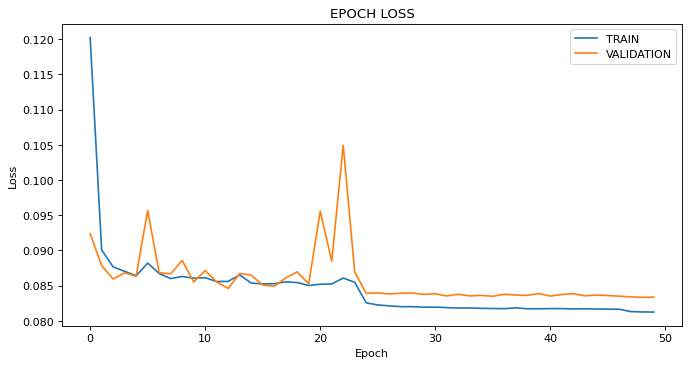

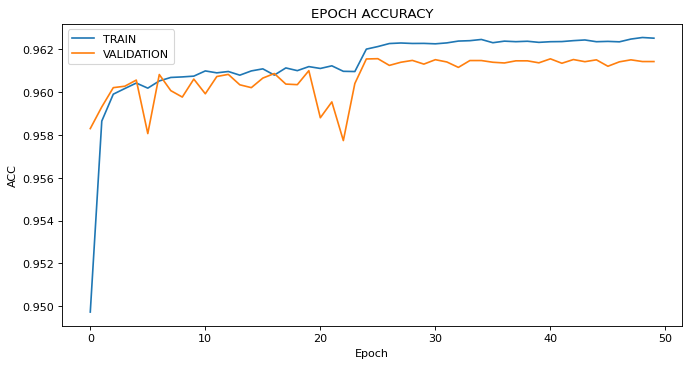

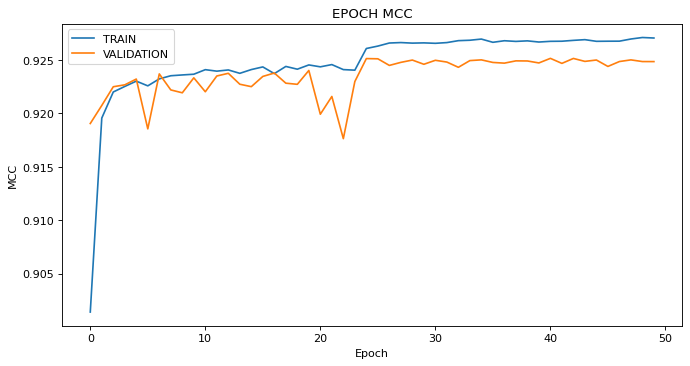

In [167]:
trainer.plot()

In [166]:
###TESTING ON THE TEST SET

model = NeuralClassifier()
use_cuda = True
if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

    
state = torch.load(os.getcwd()+'/DL_SAVES/NeuralClassifier_lr_0.02_run_10011_epoch_45.pt')
model.load_state_dict(state)

test_dataloader = DataLoader(test_set,
                            batch_size=1,
                            shuffle=False)

pred, label = get_accuracy_d(model, test_dataloader) #loss_eval, acc_eval, mcc_eval,
pred = list(itertools.chain(*pred))

target_names = ['low', 'med', 'high']
print(classification_report(label, pred, target_names=target_names))
print("MCC: ", matthews_corrcoef(label, pred))
confusion_matrix(label, pred)

CUDA is available!  Training on GPU ...
              precision    recall  f1-score   support

         low       1.00      1.00      1.00    150000
         med       0.93      0.96      0.95     87500
        high       0.66      0.51      0.58     12500

    accuracy                           0.96    250000
   macro avg       0.86      0.83      0.84    250000
weighted avg       0.96      0.96      0.96    250000

MCC:  0.9259985667350729


array([[149992,      3,      5],
       [    50,  84082,   3368],
       [    44,   6025,   6431]], dtype=int64)

#### EXPERIMENT ...

In [171]:
run = 10012
is_weights = False
total_epochs = 50
save_every = 5
lr = 0.03
device = 0  # shorthand for cuda:0
model = NeuralClassifier2() # load your model 
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                       factor=0.1, patience=5, threshold=0.0001, 
                                                       threshold_mode='rel',
                                                       cooldown=0, min_lr=0, eps=1e-08)

experiment_name = "NeuralClassifier_lr_{}_run_{}".format(lr, run)

trainer = Trainer(model, train_dataloader, val_dataloader, test_dataloader, optimizer, scheduler, device, is_weights, experiment_name, save_every)
trainer.train(total_epochs)

---------------------------------------------------------------------------
GPU0 Epoch 0
Train Loss: 0.11744835 | Val Loss: 0.08854490
Train ACC: 0.94968333 | Val ACC: 0.95930000
Train MCC: 0.90196687 | Val MCC: 0.92071784
Epoch 0 | Training checkpoint
---------------------------------------------------------------------------
GPU0 Epoch 1
Train Loss: 0.09008437 | Val Loss: 0.08879207
Train ACC: 0.95917500 | Val ACC: 0.95982667
Train MCC: 0.92063142 | Val MCC: 0.92186391
---------------------------------------------------------------------------
GPU0 Epoch 2
Train Loss: 0.08831282 | Val Loss: 0.08869125
Train ACC: 0.95978167 | Val ACC: 0.95891333
Train MCC: 0.92183124 | Val MCC: 0.92031542
---------------------------------------------------------------------------
GPU0 Epoch 3
Train Loss: 0.08680725 | Val Loss: 0.08678643
Train ACC: 0.96035833 | Val ACC: 0.96048667
Train MCC: 0.92293767 | Val MCC: 0.92303726
---------------------------------------------------------------------------
GP

---------------------------------------------------------------------------
GPU0 Epoch 36
Train Loss: 0.08112385 | Val Loss: 0.08310729
Train ACC: 0.96260333 | Val ACC: 0.96149333
Train MCC: 0.92721204 | Val MCC: 0.92497021
---------------------------------------------------------------------------
GPU0 Epoch 37
Train Loss: 0.08112406 | Val Loss: 0.08310935
Train ACC: 0.96260333 | Val ACC: 0.96151333
Train MCC: 0.92720451 | Val MCC: 0.92501074
---------------------------------------------------------------------------
GPU0 Epoch 38
Train Loss: 0.08112065 | Val Loss: 0.08311186
Train ACC: 0.96263833 | Val ACC: 0.96143333
Train MCC: 0.92727881 | Val MCC: 0.92484943
---------------------------------------------------------------------------
GPU0 Epoch 39
Train Loss: 0.08111578 | Val Loss: 0.08311122
Train ACC: 0.96262333 | Val ACC: 0.96145333
Train MCC: 0.92725901 | Val MCC: 0.92488927
---------------------------------------------------------------------------
GPU0 Epoch 40
Train Loss: 0.

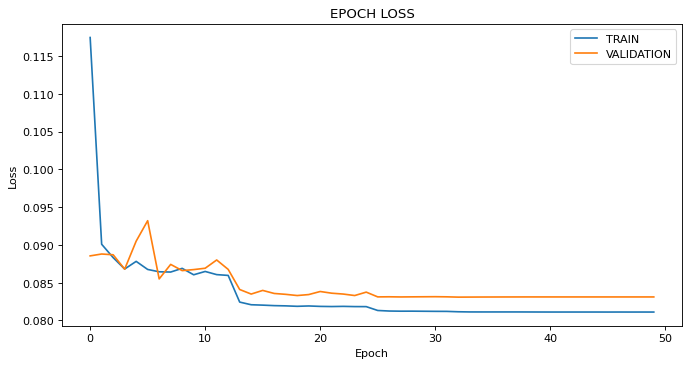

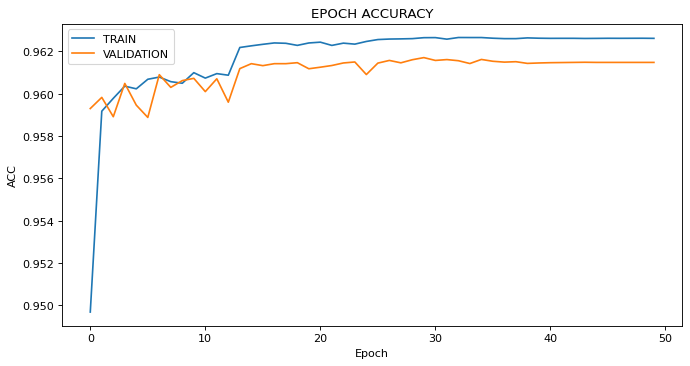

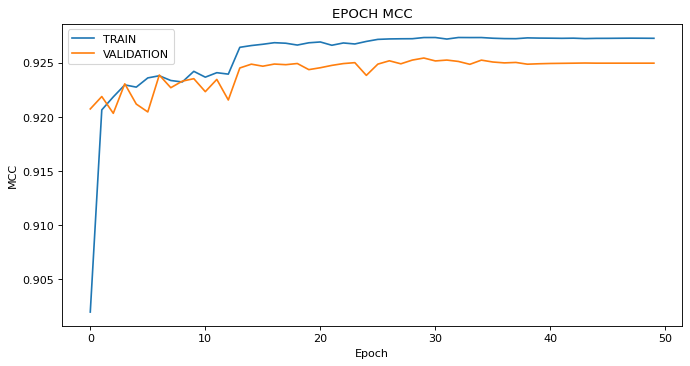

In [172]:
trainer.plot()

In [174]:
###TESTING ON THE TEST SET

model = NeuralClassifier2()
use_cuda = True
if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

    
state = torch.load(os.getcwd()+'/DL_SAVES/NeuralClassifier_lr_0.03_run_10012_epoch_45.pt')
model.load_state_dict(state)

test_dataloader = DataLoader(test_set,
                            batch_size=1,
                            shuffle=False)

pred, label = get_accuracy_d(model, test_dataloader) #loss_eval, acc_eval, mcc_eval,
pred = list(itertools.chain(*pred))

target_names = ['low', 'med', 'high']
print(classification_report(label, pred, target_names=target_names))
print("MCC: ", matthews_corrcoef(label, pred))
confusion_matrix(label, pred)

CUDA is available!  Training on GPU ...
              precision    recall  f1-score   support

         low       1.00      1.00      1.00    150000
         med       0.93      0.96      0.95     87500
        high       0.67      0.49      0.57     12500

    accuracy                           0.96    250000
   macro avg       0.87      0.82      0.84    250000
weighted avg       0.96      0.96      0.96    250000

MCC:  0.9263028665819136


array([[149992,      2,      6],
       [    50,  84380,   3070],
       [    48,   6281,   6171]], dtype=int64)

#### EXPERIMENT #2

In [108]:
!pip install focal-loss-torch

In [194]:
from focal_loss.focal_loss import FocalLoss

class Trainer_Focal:
    def __init__(
        self,
        model: torch.nn.Module,
        gamma: int,
        train_data: DataLoader,
        val_data: DataLoader,
        test_data: DataLoader,
        optimizer: torch.optim.Optimizer,
        scheduler: torch.optim.lr_scheduler,
        gpu_id: int,
        is_weights: bool,
        name: str,
        save_every: int) -> None:
        
        self.gpu_id = gpu_id
        self.model = model.to(gpu_id)
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.save_every = save_every
        self.is_weights = is_weights
        self.trainer_name = name
        self.path = os.getcwd()+"/DL_SAVES"
        self.m = torch.nn.Softmax(dim=1)
        self.gamma = gamma
        
        
    def loss_function(self):
        
        if self.is_weights==True:
            return FocalLoss(gamma=self.gamma, weights=class_weights.to(self.gpu_id)) #nn.CrossEntropyLoss(weight = class_weights.to(self.gpu_id)) 
        else: #imbalanced
            return FocalLoss(gamma=self.gamma) #nn.CrossEntropyLoss()
        
    def calculate_metrics(self, output, targets):
                
        #LOSS:
        loss_fn = self.loss_function()        
        #new = self.m(torch.subtract(output, torch.reshape(torch.max(output, 1)[0], (output.shape[0],1))))
        #new = self.m(output)
        loss = loss_fn(output, targets)
                
        #ACCURACY:
        pred = output.max(1, keepdim=True)[1]
        correct = pred.eq(targets.view_as(pred)).sum().item()
        
        #MCC SCORE:
        mcc = matthews_corrcoef(targets.cpu().detach().numpy(), pred.cpu().detach().numpy())
        
        return loss, correct, mcc
        
    
    def _run_batch(self, source, targets):
        self.optimizer.zero_grad()
        output = self.model(source.float())
        
        loss, correct, mcc = self.calculate_metrics(output, targets)
        loss.backward()
        self.optimizer.step()
        
        return loss, correct, mcc
        
    def _run_epoch(self, epoch):
        self.model.train()
        
        train_loss = 0
        train_correct = 0
        train_mcc = 0
        
        train_total = 0
        train_itr = 0
        
        for source, targets in self.train_data:
            source = source.to(self.gpu_id)
            targets = targets.to(self.gpu_id)
            batch_loss, batch_correct, batch_mcc = self._run_batch(source, targets)
            train_loss += batch_loss.item()
            train_correct += batch_correct
            train_mcc += batch_mcc
            train_total += targets.shape[0]
            
            train_itr += 1
        
        train_loss = float(train_loss)/train_itr
        train_acc = train_correct/train_total
        train_mcc = train_mcc/train_itr
            
        return train_loss, train_acc, train_mcc

    def _save_checkpoint(self, epoch):
        ckp = self.model.state_dict()
        PATH = self.path + "/{}_epoch_{}.pt".format(self.trainer_name, epoch)
        torch.save(ckp, PATH)
        print(f"Epoch {epoch} | Training checkpoint")
        
    def evaluate(self, epoch):
        self.model.eval()
        
        val_loss = 0
        val_correct = 0
        val_mcc = 0
        
        val_total = 0
        val_itr = 0
        with torch.no_grad():
            for source, targets in self.val_data:
                source = source.to(self.gpu_id)
                targets = targets.to(self.gpu_id)
                val_output = self.model(source.float())
                
                loss, correct, mcc = self.calculate_metrics(val_output, targets)
                
                val_loss += loss.item()
                val_correct += correct
                val_mcc += mcc
                val_total += targets.shape[0]
            
                val_itr += 1
        
        val_loss = float(val_loss)/val_itr
        val_acc = val_correct/val_total
        val_mcc = val_mcc/val_itr
                
        
        return val_loss, val_acc, val_mcc 
        
    def train(self, max_epochs: int):
        saves_df = pd.DataFrame()
        
        for epoch in range(max_epochs):
            train_epoch_loss, train_epoch_acc, train_epoch_mcc = self._run_epoch(epoch)
            val_epoch_loss, val_epoch_acc, val_epoch_mcc = self.evaluate(epoch)
            self.scheduler.step(val_epoch_loss)
            
            print("-"*75)
            print('GPU{} Epoch {}'.format(self.gpu_id, epoch))
            print("Train Loss: {:.8f} | Val Loss: {:.8f}".format(train_epoch_loss, val_epoch_loss))
            print("Train ACC: {:.8f} | Val ACC: {:.8f}".format(train_epoch_acc, val_epoch_acc))
            print("Train MCC: {:.8f} | Val MCC: {:.8f}".format(train_epoch_mcc, val_epoch_mcc))
            
            saves_df.loc[epoch, 'EPOCH'] = int(epoch)
            saves_df.loc[epoch, 'TRAIN_LOSS'] = train_epoch_loss
            saves_df.loc[epoch, 'VAL_LOSS'] = val_epoch_loss
            saves_df.loc[epoch, 'TRAIN_ACC'] = train_epoch_acc
            saves_df.loc[epoch, 'VAL_ACC'] = val_epoch_acc
            saves_df.loc[epoch, 'TRAIN_MCC'] = train_epoch_mcc
            saves_df.loc[epoch, 'VAL_MCC'] = val_epoch_mcc
                              
            if epoch % self.save_every == 0:
                self._save_checkpoint(epoch)
        
        saves_df.to_csv(self.path+"/{}.csv".format(self.trainer_name))
    
    def plot(self):
        
        saves_df = pd.read_csv(self.path+"/{}.csv".format(self.trainer_name))
       
        plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
        plt.plot(saves_df['EPOCH'], saves_df['TRAIN_LOSS'])
        plt.plot(saves_df['EPOCH'], saves_df['VAL_LOSS'])
        plt.legend(["TRAIN", "VALIDATION"])
        plt.title("EPOCH LOSS")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()
        
        plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
        plt.plot(saves_df['EPOCH'], saves_df['TRAIN_ACC'])
        plt.plot(saves_df['EPOCH'], saves_df['VAL_ACC'])
        plt.legend(["TRAIN", "VALIDATION"])
        plt.title("EPOCH ACCURACY")
        plt.xlabel("Epoch")
        plt.ylabel("ACC")
        plt.show()
        
        plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
        plt.plot(saves_df['EPOCH'], saves_df['TRAIN_MCC'])
        plt.plot(saves_df['EPOCH'], saves_df['VAL_MCC'])
        plt.legend(["TRAIN", "VALIDATION"])
        plt.title("EPOCH MCC")
        plt.xlabel("Epoch")
        plt.ylabel("MCC")
        plt.show()



In [192]:
run = 1002
gamma = 0.7 #FOR FOCAL LOSS
is_weights = False
total_epochs = 50
save_every = 5
lr = 0.01
device = 0  # shorthand for cuda:0
model = NeuralClassifier3() # load your model 
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                       factor=0.1, patience=5, threshold=0.0001, 
                                                       threshold_mode='rel',
                                                       cooldown=0, min_lr=0, eps=1e-08)

experiment_name = "NeuralClassifier_lr_{}_run_{}".format(lr, run)

trainer = Trainer_Focal(model, gamma, train_dataloader, val_dataloader, test_dataloader, optimizer, scheduler, device, is_weights, experiment_name, save_every)
trainer.train(total_epochs)

---------------------------------------------------------------------------
GPU0 Epoch 0
Train Loss: 0.16041376 | Val Loss: 0.10225247
Train ACC: 0.92859667 | Val ACC: 0.94964667
Train MCC: 0.85044787 | Val MCC: 0.90440982
Epoch 0 | Training checkpoint
---------------------------------------------------------------------------
GPU0 Epoch 1
Train Loss: 0.10047518 | Val Loss: 0.09925839
Train ACC: 0.94940500 | Val ACC: 0.94942667
Train MCC: 0.90387990 | Val MCC: 0.90386460
---------------------------------------------------------------------------
GPU0 Epoch 2
Train Loss: 0.09181058 | Val Loss: 0.07419200
Train ACC: 0.94964000 | Val ACC: 0.95210667
Train MCC: 0.90431710 | Val MCC: 0.90875829
---------------------------------------------------------------------------
GPU0 Epoch 3
Train Loss: 0.06966234 | Val Loss: 0.06801612
Train ACC: 0.95394667 | Val ACC: 0.95561333
Train MCC: 0.91168940 | Val MCC: 0.91444504
---------------------------------------------------------------------------
GP

---------------------------------------------------------------------------
GPU0 Epoch 36
Train Loss: 0.05071267 | Val Loss: 0.05206751
Train ACC: 0.96232167 | Val ACC: 0.96100667
Train MCC: 0.92668312 | Val MCC: 0.92401391
---------------------------------------------------------------------------
GPU0 Epoch 37
Train Loss: 0.05070925 | Val Loss: 0.05207875
Train ACC: 0.96234500 | Val ACC: 0.96102667
Train MCC: 0.92672985 | Val MCC: 0.92405039
---------------------------------------------------------------------------
GPU0 Epoch 38
Train Loss: 0.05070855 | Val Loss: 0.05207548
Train ACC: 0.96229000 | Val ACC: 0.96102000
Train MCC: 0.92661484 | Val MCC: 0.92403927
---------------------------------------------------------------------------
GPU0 Epoch 39
Train Loss: 0.05070022 | Val Loss: 0.05208394
Train ACC: 0.96233167 | Val ACC: 0.96107333
Train MCC: 0.92669744 | Val MCC: 0.92414851
---------------------------------------------------------------------------
GPU0 Epoch 40
Train Loss: 0.

In [193]:
###TESTING ON THE TEST SET

model = NeuralClassifier3()
use_cuda = True
if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

    
state = torch.load(os.getcwd()+'/DL_SAVES/NeuralClassifier_lr_0.01_run_1002_epoch_45.pt')
model.load_state_dict(state)

test_dataloader = DataLoader(test_set,
                            batch_size=1,
                            shuffle=False)

pred, label = get_accuracy_d(model, test_dataloader) #loss_eval, acc_eval, mcc_eval,
pred = list(itertools.chain(*pred))

target_names = ['low', 'med', 'high']
print(classification_report(label, pred, target_names=target_names))
print("MCC: ", matthews_corrcoef(label, pred))
confusion_matrix(label, pred)

CUDA is available!  Training on GPU ...
              precision    recall  f1-score   support

         low       1.00      1.00      1.00    150000
         med       0.93      0.97      0.95     87500
        high       0.67      0.48      0.56     12500

    accuracy                           0.96    250000
   macro avg       0.87      0.81      0.83    250000
weighted avg       0.96      0.96      0.96    250000

MCC:  0.9255847356995516


array([[149985,     15,      0],
       [    46,  84507,   2947],
       [    43,   6500,   5957]], dtype=int64)

In [195]:
run = 1003
gamma = 2 #FOR FOCAL LOSS
is_weights = False
total_epochs = 50
save_every = 5
lr = 0.01
device = 0  # shorthand for cuda:0
model = NeuralClassifier3() # load your model 
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                       factor=0.1, patience=5, threshold=0.0001, 
                                                       threshold_mode='rel',
                                                       cooldown=0, min_lr=0, eps=1e-08)

experiment_name = "NeuralClassifier_lr_{}_run_{}".format(lr, run)

trainer = Trainer_Focal(model, gamma, train_dataloader, val_dataloader, 
                        test_dataloader, optimizer, scheduler, device, 
                        is_weights, experiment_name, save_every)

trainer.train(total_epochs)

---------------------------------------------------------------------------
GPU0 Epoch 0
Train Loss: 0.06510583 | Val Loss: 0.04390519
Train ACC: 0.94142667 | Val ACC: 0.94958667
Train MCC: 0.88606809 | Val MCC: 0.90421944
Epoch 0 | Training checkpoint
---------------------------------------------------------------------------
GPU0 Epoch 1
Train Loss: 0.04132794 | Val Loss: 0.03099925
Train ACC: 0.94990500 | Val ACC: 0.95312000
Train MCC: 0.90466415 | Val MCC: 0.91019063
---------------------------------------------------------------------------
GPU0 Epoch 2
Train Loss: 0.02696576 | Val Loss: 0.02466548
Train ACC: 0.95726000 | Val ACC: 0.95842000
Train MCC: 0.91709906 | Val MCC: 0.91902340
---------------------------------------------------------------------------
GPU0 Epoch 3
Train Loss: 0.02475531 | Val Loss: 0.02403168
Train ACC: 0.95919833 | Val ACC: 0.95896667
Train MCC: 0.92069609 | Val MCC: 0.92053871
---------------------------------------------------------------------------
GP

---------------------------------------------------------------------------
GPU0 Epoch 36
Train Loss: 0.02163627 | Val Loss: 0.02222025
Train ACC: 0.96218000 | Val ACC: 0.96094667
Train MCC: 0.92639050 | Val MCC: 0.92392293
---------------------------------------------------------------------------
GPU0 Epoch 37
Train Loss: 0.02163573 | Val Loss: 0.02221722
Train ACC: 0.96215500 | Val ACC: 0.96122000
Train MCC: 0.92635019 | Val MCC: 0.92447367
---------------------------------------------------------------------------
GPU0 Epoch 38
Train Loss: 0.02163782 | Val Loss: 0.02212502
Train ACC: 0.96226667 | Val ACC: 0.96116000
Train MCC: 0.92656401 | Val MCC: 0.92435544
---------------------------------------------------------------------------
GPU0 Epoch 39
Train Loss: 0.02162438 | Val Loss: 0.02217463
Train ACC: 0.96217000 | Val ACC: 0.96106000
Train MCC: 0.92638175 | Val MCC: 0.92415326
---------------------------------------------------------------------------
GPU0 Epoch 40
Train Loss: 0.

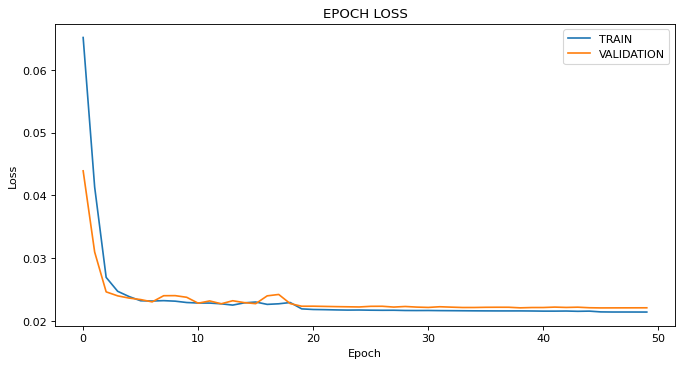

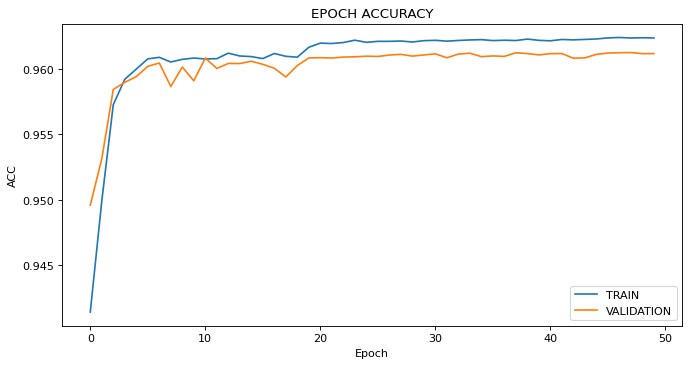

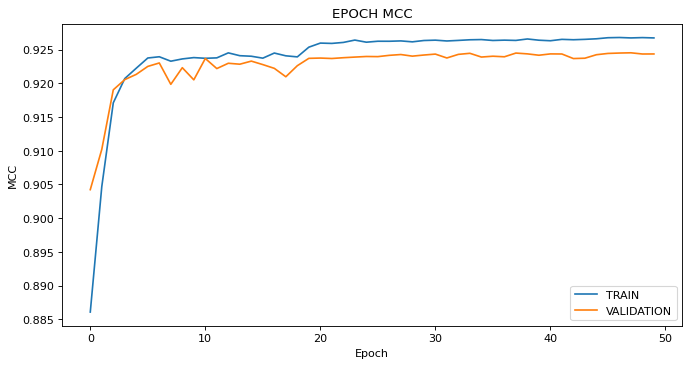

In [197]:
trainer.plot()

In [196]:
###TESTING ON THE TEST SET

model = NeuralClassifier3()
use_cuda = True
if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

    
state = torch.load(os.getcwd()+'/DL_SAVES/NeuralClassifier_lr_0.01_run_1003_epoch_45.pt')
model.load_state_dict(state)

test_dataloader = DataLoader(test_set,
                            batch_size=1,
                            shuffle=False)

pred, label = get_accuracy_d(model, test_dataloader) #loss_eval, acc_eval, mcc_eval,
pred = list(itertools.chain(*pred))

target_names = ['low', 'med', 'high']
print(classification_report(label, pred, target_names=target_names))
print("MCC: ", matthews_corrcoef(label, pred))
confusion_matrix(label, pred)

CUDA is available!  Training on GPU ...
              precision    recall  f1-score   support

         low       1.00      1.00      1.00    150000
         med       0.93      0.97      0.95     87500
        high       0.67      0.48      0.56     12500

    accuracy                           0.96    250000
   macro avg       0.87      0.82      0.84    250000
weighted avg       0.96      0.96      0.96    250000

MCC:  0.925999006675316


array([[149993,      2,      5],
       [    50,  84466,   2984],
       [    42,   6414,   6044]], dtype=int64)

In [198]:
run = 1004
gamma = 5 #FOR FOCAL LOSS
is_weights = False
total_epochs = 50
save_every = 5
lr = 0.01
device = 0  # shorthand for cuda:0
model = NeuralClassifier3() # load your model 
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                       factor=0.1, patience=5, threshold=0.0001, 
                                                       threshold_mode='rel',
                                                       cooldown=0, min_lr=0, eps=1e-08)

experiment_name = "NeuralClassifier_lr_{}_run_{}".format(lr, run)

trainer = Trainer_Focal(model, gamma, train_dataloader, val_dataloader, 
                        test_dataloader, optimizer, scheduler, device, 
                        is_weights, experiment_name, save_every)

trainer.train(total_epochs)

---------------------------------------------------------------------------
GPU0 Epoch 0
Train Loss: 0.01579797 | Val Loss: 0.00735492
Train ACC: 0.93901667 | Val ACC: 0.94915333
Train MCC: 0.87905063 | Val MCC: 0.90324647
Epoch 0 | Training checkpoint
---------------------------------------------------------------------------
GPU0 Epoch 1
Train Loss: 0.00651878 | Val Loss: 0.00620887
Train ACC: 0.94940667 | Val ACC: 0.94955333
Train MCC: 0.90389170 | Val MCC: 0.90415590
---------------------------------------------------------------------------
GPU0 Epoch 2
Train Loss: 0.00596741 | Val Loss: 0.00510292
Train ACC: 0.94968667 | Val ACC: 0.95328000
Train MCC: 0.90437679 | Val MCC: 0.91001026
---------------------------------------------------------------------------
GPU0 Epoch 3
Train Loss: 0.00458642 | Val Loss: 0.00410591
Train ACC: 0.95381667 | Val ACC: 0.95468000
Train MCC: 0.91110595 | Val MCC: 0.91252235
---------------------------------------------------------------------------
GP

---------------------------------------------------------------------------
GPU0 Epoch 36
Train Loss: 0.00301763 | Val Loss: 0.00309987
Train ACC: 0.96165667 | Val ACC: 0.96144000
Train MCC: 0.92538689 | Val MCC: 0.92490834
---------------------------------------------------------------------------
GPU0 Epoch 37
Train Loss: 0.00298775 | Val Loss: 0.00307924
Train ACC: 0.96191667 | Val ACC: 0.96141333
Train MCC: 0.92590444 | Val MCC: 0.92485767
---------------------------------------------------------------------------
GPU0 Epoch 38
Train Loss: 0.00298387 | Val Loss: 0.00307898
Train ACC: 0.96187500 | Val ACC: 0.96124000
Train MCC: 0.92580194 | Val MCC: 0.92455465
---------------------------------------------------------------------------
GPU0 Epoch 39
Train Loss: 0.00298226 | Val Loss: 0.00307653
Train ACC: 0.96186167 | Val ACC: 0.96128667
Train MCC: 0.92577898 | Val MCC: 0.92461959
---------------------------------------------------------------------------
GPU0 Epoch 40
Train Loss: 0.

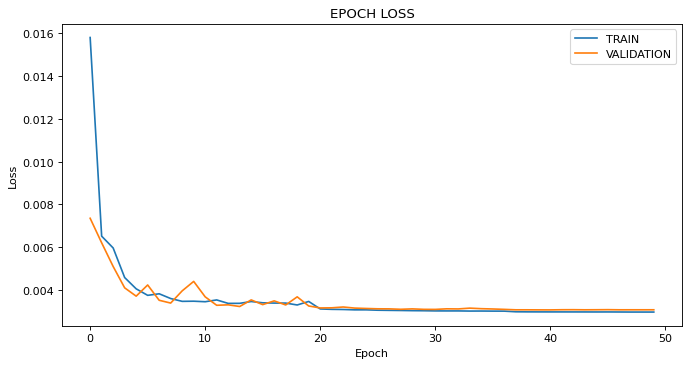

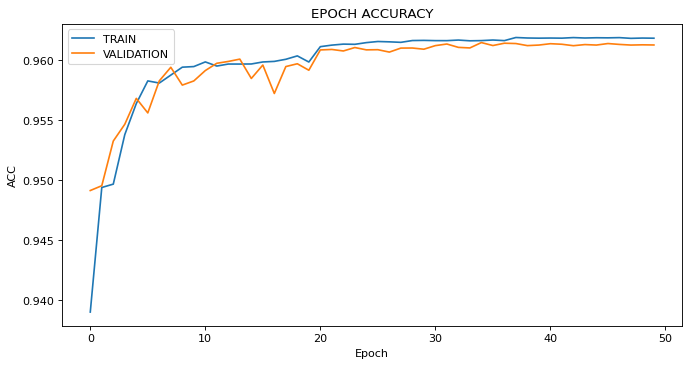

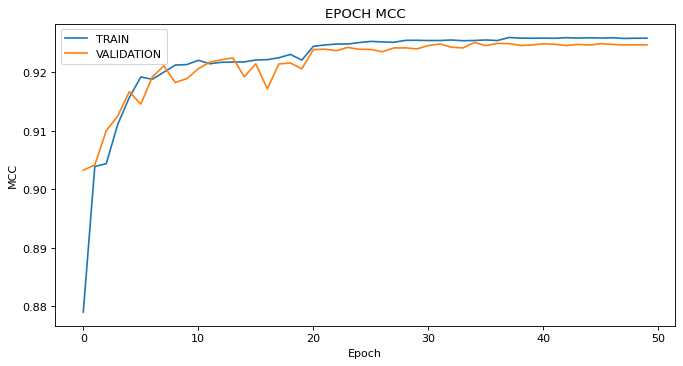

In [199]:
trainer.plot()

In [200]:
###TESTING ON THE TEST SET

model = NeuralClassifier3()
use_cuda = True
if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

    
state = torch.load(os.getcwd()+'/DL_SAVES/NeuralClassifier_lr_0.01_run_1004_epoch_45.pt')
model.load_state_dict(state)

test_dataloader = DataLoader(test_set,
                            batch_size=1,
                            shuffle=False)

pred, label = get_accuracy_d(model, test_dataloader) #loss_eval, acc_eval, mcc_eval,
pred = list(itertools.chain(*pred))

target_names = ['low', 'med', 'high']
print(classification_report(label, pred, target_names=target_names))
print("MCC: ", matthews_corrcoef(label, pred))
confusion_matrix(label, pred)

CUDA is available!  Training on GPU ...
              precision    recall  f1-score   support

         low       1.00      1.00      1.00    150000
         med       0.93      0.96      0.95     87500
        high       0.66      0.50      0.57     12500

    accuracy                           0.96    250000
   macro avg       0.86      0.82      0.84    250000
weighted avg       0.96      0.96      0.96    250000

MCC:  0.9256016440904479


array([[149982,     13,      5],
       [    45,  84276,   3179],
       [    31,   6274,   6195]], dtype=int64)

### BAL

In [99]:
run = 2001

is_weights = True
class_weights_1 = {0: 0.999999999998889, 1: 1.338346, 2: 2.736842}
class_weights = torch.tensor(list(class_weights_1.values()),dtype=torch.float)

total_epochs = 50
save_every = 5
lr = 0.05
device = 0  # shorthand for cuda:0
model = NeuralClassifier() # load your model 
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                       factor=0.1, patience=10, threshold=0.0001, 
                                                       threshold_mode='rel',
                                                       cooldown=0, min_lr=0, eps=1e-08)

experiment_name = "NeuralClassifier_lr_{}_run_{}".format(lr, run)

trainer = Trainer(model, train_dataloader, val_dataloader, test_dataloader, optimizer, scheduler, device, is_weights, experiment_name, save_every)
trainer.train(total_epochs)

---------------------------------------------------------------------------
GPU0 Epoch 0
Train Loss: 0.17356935 | Val Loss: 0.14844455
Train ACC: 0.94718500 | Val ACC: 0.95383333
Train MCC: 0.89900551 | Val MCC: 0.91119178
Epoch 0 | Training checkpoint
---------------------------------------------------------------------------
GPU0 Epoch 1
Train Loss: 0.15131329 | Val Loss: 0.14837201
Train ACC: 0.95243333 | Val ACC: 0.95124667
Train MCC: 0.90928686 | Val MCC: 0.90726695
---------------------------------------------------------------------------
GPU0 Epoch 2
Train Loss: 0.14672771 | Val Loss: 0.14601536
Train ACC: 0.95364333 | Val ACC: 0.95028000
Train MCC: 0.91160968 | Val MCC: 0.90606636
---------------------------------------------------------------------------
GPU0 Epoch 3
Train Loss: 0.14638777 | Val Loss: 0.14827808
Train ACC: 0.95409833 | Val ACC: 0.95716667
Train MCC: 0.91232821 | Val MCC: 0.91712988
---------------------------------------------------------------------------
GP

---------------------------------------------------------------------------
GPU0 Epoch 36
Train Loss: 0.13546417 | Val Loss: 0.13839679
Train ACC: 0.95720333 | Val ACC: 0.95682667
Train MCC: 0.91802983 | Val MCC: 0.91699586
---------------------------------------------------------------------------
GPU0 Epoch 37
Train Loss: 0.13570905 | Val Loss: 0.13916546
Train ACC: 0.95713500 | Val ACC: 0.95822000
Train MCC: 0.91788941 | Val MCC: 0.91935388
---------------------------------------------------------------------------
GPU0 Epoch 38
Train Loss: 0.13536390 | Val Loss: 0.13831287
Train ACC: 0.95722667 | Val ACC: 0.95680667
Train MCC: 0.91806868 | Val MCC: 0.91704332
---------------------------------------------------------------------------
GPU0 Epoch 39
Train Loss: 0.13535509 | Val Loss: 0.13887178
Train ACC: 0.95725167 | Val ACC: 0.95700667
Train MCC: 0.91810804 | Val MCC: 0.91720649
---------------------------------------------------------------------------
GPU0 Epoch 40
Train Loss: 0.

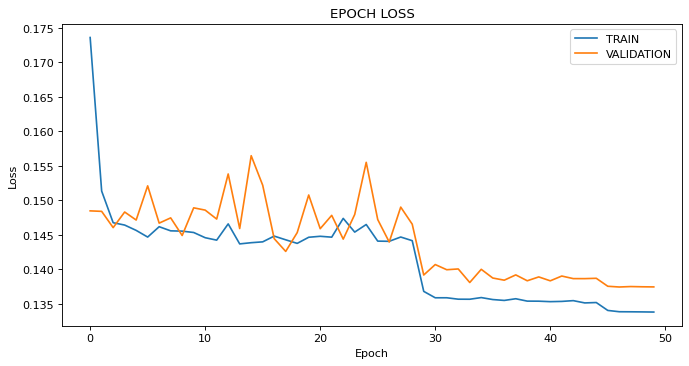

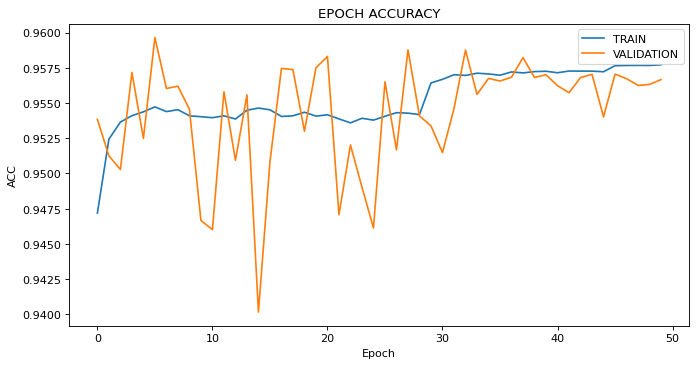

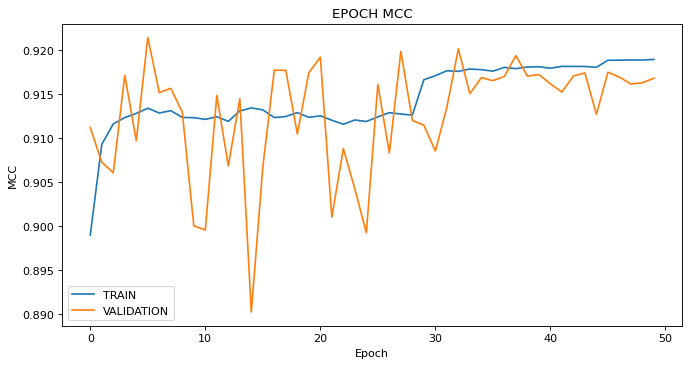

In [100]:
trainer.plot()

In [101]:
model = NeuralClassifier()
use_cuda = True
if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

    
state = torch.load(os.getcwd()+'/DL_SAVES/NeuralClassifier_lr_0.05_run_2001_epoch_45.pt')
model.load_state_dict(state)

CUDA is available!  Training on GPU ...


<All keys matched successfully>

In [103]:
pred, label = get_accuracy_d(model, test_dataloader) #loss_eval, acc_eval, mcc_eval,
pred = list(itertools.chain(*pred))

target_names = ['low', 'med', 'high']
print(classification_report(label, pred, target_names=target_names))
print("MCC: ", matthews_corrcoef(label, pred))
confusion_matrix(label, pred)

              precision    recall  f1-score   support

         low       1.00      1.00      1.00    150000
         med       0.96      0.92      0.94     87500
        high       0.57      0.70      0.63     12500

    accuracy                           0.96    250000
   macro avg       0.84      0.87      0.85    250000
weighted avg       0.96      0.96      0.96    250000

MCC:  0.9190740241681046


array([[149975,      2,     23],
       [    44,  80763,   6693],
       [    31,   3732,   8737]], dtype=int64)

In [201]:
run = 2002
gamma = 2 #FOR FOCAL LOSS

is_weights = True
class_weights_1 = {0: 0.999999999998889, 1: 1.338346, 2: 2.736842}
class_weights = torch.tensor(list(class_weights_1.values()),dtype=torch.float)

total_epochs = 50
save_every = 5
lr = 0.01
device = 0  # shorthand for cuda:0
model = NeuralClassifier3() # load your model 
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                       factor=0.1, patience=5, threshold=0.0001, 
                                                       threshold_mode='rel',
                                                       cooldown=0, min_lr=0, eps=1e-08)

experiment_name = "NeuralClassifier_lr_{}_run_{}".format(lr, run)

trainer = Trainer_Focal(model, gamma, train_dataloader, val_dataloader, 
                        test_dataloader, optimizer, scheduler, device, 
                        is_weights, experiment_name, save_every)

trainer.train(total_epochs)

---------------------------------------------------------------------------
GPU0 Epoch 0
Train Loss: 0.09796267 | Val Loss: 0.04747925
Train ACC: 0.92957667 | Val ACC: 0.95235333
Train MCC: 0.86250030 | Val MCC: 0.90785697
Epoch 0 | Training checkpoint
---------------------------------------------------------------------------
GPU0 Epoch 1
Train Loss: 0.04276323 | Val Loss: 0.04184954
Train ACC: 0.95173333 | Val ACC: 0.94459333
Train MCC: 0.90763905 | Val MCC: 0.89658785
---------------------------------------------------------------------------
GPU0 Epoch 2
Train Loss: 0.03930799 | Val Loss: 0.03854068
Train ACC: 0.95360833 | Val ACC: 0.95442667
Train MCC: 0.91140891 | Val MCC: 0.91261441
---------------------------------------------------------------------------
GPU0 Epoch 3
Train Loss: 0.03838143 | Val Loss: 0.03798400
Train ACC: 0.95394833 | Val ACC: 0.95544667
Train MCC: 0.91214871 | Val MCC: 0.91450757
---------------------------------------------------------------------------
GP

---------------------------------------------------------------------------
GPU0 Epoch 36
Train Loss: 0.03507335 | Val Loss: 0.03616687
Train ACC: 0.95737167 | Val ACC: 0.95562000
Train MCC: 0.91832684 | Val MCC: 0.91503577
---------------------------------------------------------------------------
GPU0 Epoch 37
Train Loss: 0.03505045 | Val Loss: 0.03612807
Train ACC: 0.95718333 | Val ACC: 0.95425333
Train MCC: 0.91799296 | Val MCC: 0.91294866
---------------------------------------------------------------------------
GPU0 Epoch 38
Train Loss: 0.03502987 | Val Loss: 0.03604713
Train ACC: 0.95731833 | Val ACC: 0.95557333
Train MCC: 0.91824974 | Val MCC: 0.91502266
---------------------------------------------------------------------------
GPU0 Epoch 39
Train Loss: 0.03502434 | Val Loss: 0.03614629
Train ACC: 0.95735500 | Val ACC: 0.95614667
Train MCC: 0.91830198 | Val MCC: 0.91594607
---------------------------------------------------------------------------
GPU0 Epoch 40
Train Loss: 0.

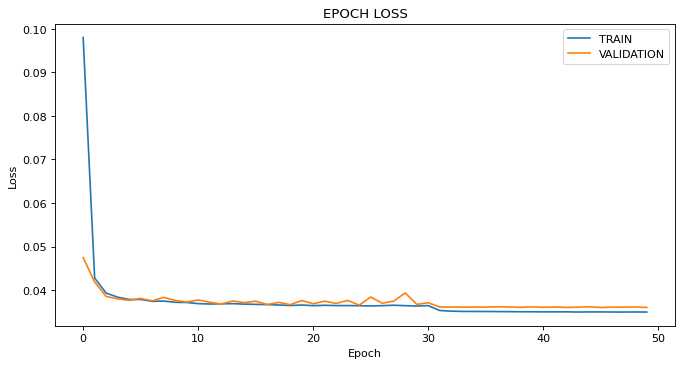

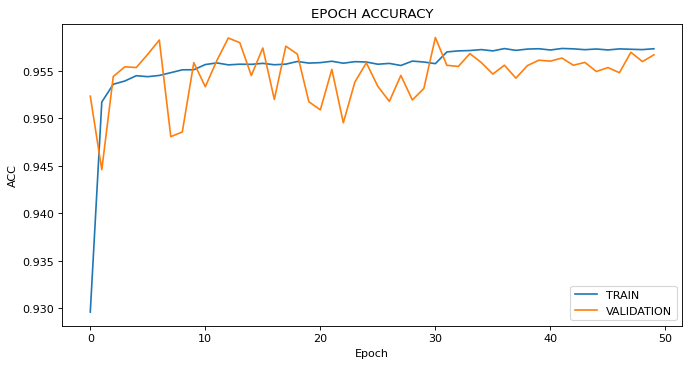

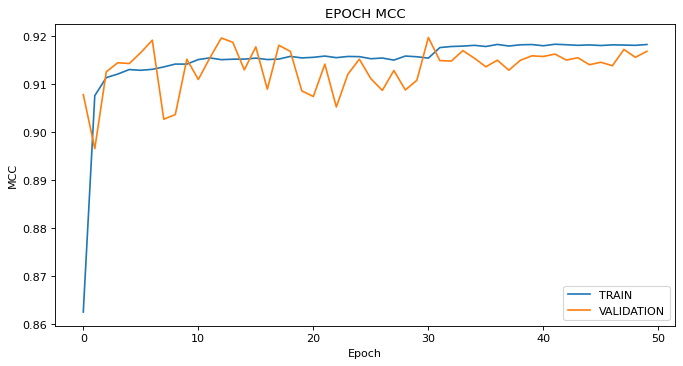

In [202]:
trainer.plot()

In [203]:
###TESTING ON THE TEST SET

model = NeuralClassifier3()
use_cuda = True
if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

    
state = torch.load(os.getcwd()+'/DL_SAVES/NeuralClassifier_lr_0.01_run_2002_epoch_45.pt')
model.load_state_dict(state)

test_dataloader = DataLoader(test_set,
                            batch_size=1,
                            shuffle=False)

pred, label = get_accuracy_d(model, test_dataloader) #loss_eval, acc_eval, mcc_eval,
pred = list(itertools.chain(*pred))

target_names = ['low', 'med', 'high']
print(classification_report(label, pred, target_names=target_names))
print("MCC: ", matthews_corrcoef(label, pred))
confusion_matrix(label, pred)

CUDA is available!  Training on GPU ...
              precision    recall  f1-score   support

         low       1.00      1.00      1.00    150000
         med       0.96      0.91      0.94     87500
        high       0.55      0.72      0.62     12500

    accuracy                           0.96    250000
   macro avg       0.84      0.88      0.85    250000
weighted avg       0.96      0.96      0.96    250000

MCC:  0.9160311293144727


array([[149965,      4,     31],
       [    43,  80030,   7427],
       [    29,   3440,   9031]], dtype=int64)

In [204]:
run = 2003
gamma = 5 #FOR FOCAL LOSS

is_weights = True
class_weights_1 = {0: 0.999999999998889, 1: 1.338346, 2: 2.736842}
class_weights = torch.tensor(list(class_weights_1.values()),dtype=torch.float)

total_epochs = 50
save_every = 5
lr = 0.01
device = 0  # shorthand for cuda:0
model = NeuralClassifier3() # load your model 
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                       factor=0.1, patience=5, threshold=0.0001, 
                                                       threshold_mode='rel',
                                                       cooldown=0, min_lr=0, eps=1e-08)

experiment_name = "NeuralClassifier_lr_{}_run_{}".format(lr, run)

trainer = Trainer_Focal(model, gamma, train_dataloader, val_dataloader, 
                        test_dataloader, optimizer, scheduler, device, 
                        is_weights, experiment_name, save_every)

trainer.train(total_epochs)

---------------------------------------------------------------------------
GPU0 Epoch 0
Train Loss: 0.01410100 | Val Loss: 0.00688005
Train ACC: 0.93601333 | Val ACC: 0.93422000
Train MCC: 0.87625906 | Val MCC: 0.87910749
Epoch 0 | Training checkpoint
---------------------------------------------------------------------------
GPU0 Epoch 1
Train Loss: 0.00643522 | Val Loss: 0.00647421
Train ACC: 0.94508333 | Val ACC: 0.95166667
Train MCC: 0.89606271 | Val MCC: 0.90648008
---------------------------------------------------------------------------
GPU0 Epoch 2
Train Loss: 0.00619939 | Val Loss: 0.00623828
Train ACC: 0.94700833 | Val ACC: 0.94408667
Train MCC: 0.89924280 | Val MCC: 0.89438894
---------------------------------------------------------------------------
GPU0 Epoch 3
Train Loss: 0.00589127 | Val Loss: 0.00568165
Train ACC: 0.94870667 | Val ACC: 0.95124000
Train MCC: 0.90231979 | Val MCC: 0.90659728
---------------------------------------------------------------------------
GP

---------------------------------------------------------------------------
GPU0 Epoch 36
Train Loss: 0.00484085 | Val Loss: 0.00497410
Train ACC: 0.95673500 | Val ACC: 0.95706667
Train MCC: 0.91712624 | Val MCC: 0.91735126
---------------------------------------------------------------------------
GPU0 Epoch 37
Train Loss: 0.00483218 | Val Loss: 0.00498330
Train ACC: 0.95675500 | Val ACC: 0.95229333
Train MCC: 0.91715957 | Val MCC: 0.90962087
---------------------------------------------------------------------------
GPU0 Epoch 38
Train Loss: 0.00480375 | Val Loss: 0.00490872
Train ACC: 0.95658667 | Val ACC: 0.95628000
Train MCC: 0.91690816 | Val MCC: 0.91614860
---------------------------------------------------------------------------
GPU0 Epoch 39
Train Loss: 0.00478934 | Val Loss: 0.00490385
Train ACC: 0.95691833 | Val ACC: 0.95554000
Train MCC: 0.91747329 | Val MCC: 0.91493083
---------------------------------------------------------------------------
GPU0 Epoch 40
Train Loss: 0.

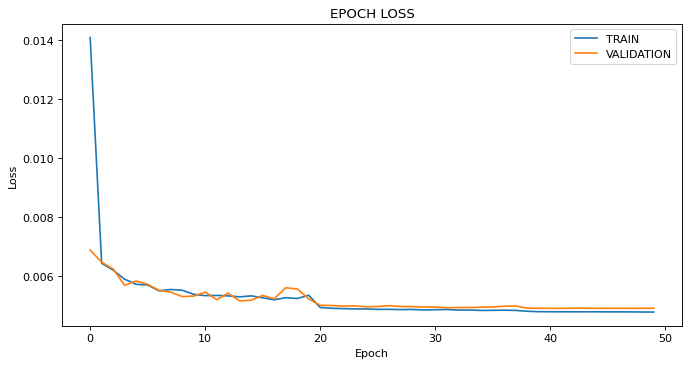

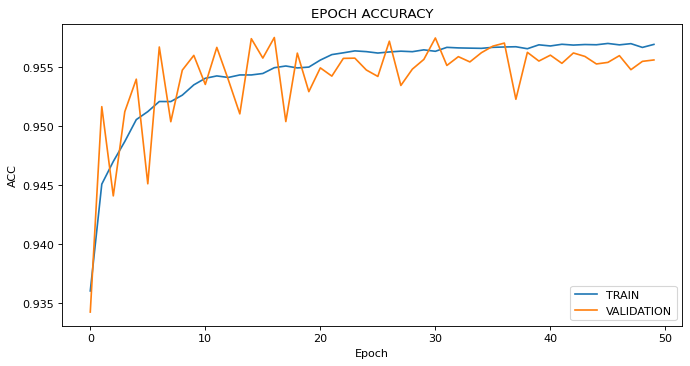

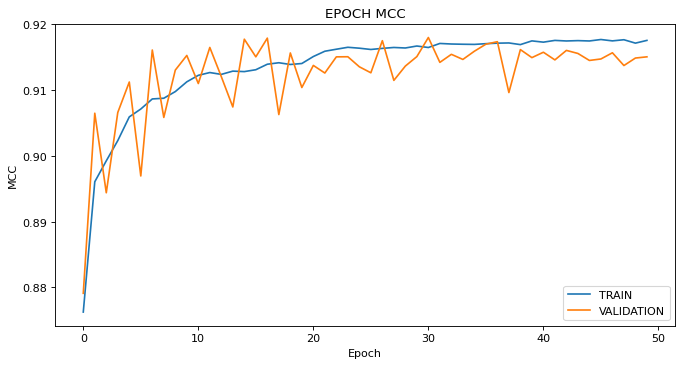

In [205]:
trainer.plot()

In [206]:
###TESTING ON THE TEST SET

model = NeuralClassifier3()
use_cuda = True
if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

    
state = torch.load(os.getcwd()+'/DL_SAVES/NeuralClassifier_lr_0.01_run_2003_epoch_45.pt')
model.load_state_dict(state)

test_dataloader = DataLoader(test_set,
                            batch_size=1,
                            shuffle=False)

pred, label = get_accuracy_d(model, test_dataloader) #loss_eval, acc_eval, mcc_eval,
pred = list(itertools.chain(*pred))

target_names = ['low', 'med', 'high']
print(classification_report(label, pred, target_names=target_names))
print("MCC: ", matthews_corrcoef(label, pred))
confusion_matrix(label, pred)

CUDA is available!  Training on GPU ...
              precision    recall  f1-score   support

         low       1.00      1.00      1.00    150000
         med       0.96      0.92      0.94     87500
        high       0.55      0.71      0.62     12500

    accuracy                           0.96    250000
   macro avg       0.84      0.88      0.85    250000
weighted avg       0.96      0.96      0.96    250000

MCC:  0.9164870967034915


array([[149973,      0,     27],
       [    42,  80194,   7264],
       [    30,   3537,   8933]], dtype=int64)

## TABNET

In [259]:
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier

clf = TabNetClassifier(
    n_d=64, n_a=64, n_steps=5,
    gamma=1.5, n_independent=2, n_shared=2,
    lambda_sparse=1e-4, momentum=0.3, clip_value=2.,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params = {"gamma": 0.95,
                     "step_size": 20},
    scheduler_fn=torch.optim.lr_scheduler.StepLR, 
    epsilon=1e-15
)

clf.fit(
  X_train.values, y_train.values,
  eval_set=[(X_val.values, y_val.values)]
)

preds = clf.predict(X_test.values)

epoch 0  | loss: 0.14103 | val_0_accuracy: 0.95105 |  0:01:09s
epoch 1  | loss: 0.11168 | val_0_accuracy: 0.95151 |  0:02:18s
epoch 2  | loss: 0.10594 | val_0_accuracy: 0.95515 |  0:03:24s
epoch 3  | loss: 0.09765 | val_0_accuracy: 0.95737 |  0:04:30s
epoch 4  | loss: 0.09279 | val_0_accuracy: 0.95904 |  0:05:36s
epoch 5  | loss: 0.08995 | val_0_accuracy: 0.95942 |  0:06:41s
epoch 6  | loss: 0.08898 | val_0_accuracy: 0.95951 |  0:07:48s
epoch 7  | loss: 0.08819 | val_0_accuracy: 0.96035 |  0:08:54s
epoch 8  | loss: 0.08731 | val_0_accuracy: 0.96055 |  0:10:00s
epoch 9  | loss: 0.08651 | val_0_accuracy: 0.95963 |  0:11:07s
epoch 10 | loss: 0.0855  | val_0_accuracy: 0.96142 |  0:12:13s
epoch 11 | loss: 0.08536 | val_0_accuracy: 0.96069 |  0:13:19s
epoch 12 | loss: 0.08431 | val_0_accuracy: 0.96127 |  0:14:24s
epoch 13 | loss: 0.0846  | val_0_accuracy: 0.96148 |  0:15:29s
epoch 14 | loss: 0.0844  | val_0_accuracy: 0.95899 |  0:16:35s
epoch 15 | loss: 0.08411 | val_0_accuracy: 0.95998 |  0

In [261]:
target_names = ['low', 'med', 'high']
pred_all = preds#[int(preds[0][i]) for i in range(len(preds[0]))]

print(classification_report(y_test.values, pred_all, target_names=target_names))
print("MCC: ", matthews_corrcoef(y_test.values, pred_all))
confusion_matrix(y_test.values, pred_all)

              precision    recall  f1-score   support

         low       1.00      1.00      1.00    150000
         med       0.93      0.97      0.95     87500
        high       0.69      0.45      0.54     12500

    accuracy                           0.96    250000
   macro avg       0.87      0.81      0.83    250000
weighted avg       0.96      0.96      0.96    250000

MCC:  0.9260954748410855


array([[149994,      1,      5],
       [    64,  84931,   2505],
       [    54,   6864,   5582]], dtype=int64)